## 1. Import Data and Normalize it

In [10]:
import torch

X_tensor = torch.load("../../data/raw/X_tensor_aftershocks_filtered.pt")
y_tensor = torch.load("../../data/raw/y_tensor_aftershocks_filtered.pt")

In [11]:
X_tensor.size()

torch.Size([16234, 29, 6])

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data_z_normalization(X_tensor, y_tensor, test_size=0.2, val_size=0.1):
    # Convert tensors to NumPy for preprocessing
    X_np = X_tensor.numpy()
    y_np = y_tensor.numpy()

    # Reshape X_np from (num_samples, num_timesteps, num_features) to (num_samples * num_timesteps, num_features)
    num_samples, num_timesteps, num_features = X_np.shape
    X_reshaped = X_np.reshape(-1, num_features)

    # Apply Z-normalization (Standardization) across the entire dataset for each feature
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)

    # Reshape back to (num_samples, num_timesteps, num_features)
    X_scaled = X_scaled.reshape(num_samples, num_timesteps, num_features)

    # Split the data into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_np, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

    # Convert back to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = preprocess_data_z_normalization(X_tensor, y_tensor)

In [13]:
print(f"Training set size (X_train, y_train): {X_train_tensor.size()}, {y_train_tensor.size()}")
print(f"Validation set size (X_val, y_val): {X_val_tensor.size()}, {y_val_tensor.size()}")
print(f"Test set size (X_test, y_test): {X_test_tensor.size()}, {y_test_tensor.size()}")

Training set size (X_train, y_train): torch.Size([11688, 29, 6]), torch.Size([11688])
Validation set size (X_val, y_val): torch.Size([1299, 29, 6]), torch.Size([1299])
Test set size (X_test, y_test): torch.Size([3247, 29, 6]), torch.Size([3247])


## 2. Get Data Ready

### 2.1 Custom Dataset Implementation
Using PyTorch `torch.utils.data` package's `Dataset` class I will create custom dataset for data generated above. 

In [14]:
import torch
from torch.utils.data import Dataset

# Custom dataset class
class EarthquakeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)  # Return the number of samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### 2.2 Create Datasets and Dataloaders

After creating my custom dataset now I need to create instances of `EarthquakeDataset`.
Also, I need to create a loader for dataset. In order to do that I will use PyTorch `torch.utils.data` package's `DataLoader` class.

In [15]:
# Create dataset instances from implemented custom dataset class.
train_dataset = EarthquakeDataset(X_train_tensor, y_train_tensor)
val_dataset = EarthquakeDataset(X_val_tensor, y_val_tensor)
test_dataset = EarthquakeDataset(X_test_tensor, y_test_tensor)

In [16]:
from torch.utils.data import DataLoader

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    # Create dataset objects
    train_dataset = EarthquakeDataset(X_train, y_train)
    val_dataset = EarthquakeDataset(X_val, y_val)
    test_dataset = EarthquakeDataset(X_test, y_test)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [17]:
import torch.nn as nn

# Custom neural network model using nn.Sequential with dynamic hidden sizes
class EarthquakeClassifier(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, output_size):
        super(EarthquakeClassifier, self).__init__()

        # Define layers using nn.Sequential
        self.stacked_layers = nn.Sequential(
            nn.Flatten(),  # Flatten the input from [batch_size, 29, 6] to [batch_size, 174]

            nn.Linear(input_size, hidden1_size),
            nn.ReLU(),

            # Second hidden layer
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),

            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),

            nn.Linear(hidden3_size, hidden4_size),
            nn.ReLU(),

            # Output layer (no Sigmoid here since we're using BCEWithLogitsLoss)
            nn.Linear(hidden4_size, output_size)
        )

    def forward(self, x):
        return self.stacked_layers(x)


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import optuna

def objective(trial):
    # Suggest values for the hyperparameters
    hidden1_size  = trial.suggest_int('hidden1_size', 64, 256)  # Hidden layer 1 size
    hidden2_size  = trial.suggest_int('hidden2_size', 64, 256)  # Hidden layer 2 size
    hidden3_size   = trial.suggest_int('hidden3_size', 32, 128)   # Hidden layer 3 size
    hidden4_size   = trial.suggest_int('hidden4_size', 16, 64)    # Hidden layer 4 size
    num_epochs    = trial.suggest_int('num_epochs', 10, 100)    # Number of epochs
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)  # Learning rate
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Create training and validation datasets and dataloaders
    train_loader, val_loader, _ = create_dataloaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size=64)

    # Initialize the model with suggested hyperparameters
    model = EarthquakeClassifier(input_size=29*6, hidden1_size=hidden1_size, hidden2_size=hidden2_size, hidden3_size=hidden3_size, hidden4_size=hidden4_size, output_size=1).to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for binary classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze(-1)  # No sigmoid since using BCEWithLogitsLoss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate the model for validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    # Return the average validation loss of the trained model
    val_loss /= len(val_loader)
    print(f"Average Validation Loss: {val_loss:.4f}")

    return val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Print the best parameters
print('Best parameters: ', study.best_params)

[I 2024-09-09 20:24:19,589] A new study created in memory with name: no-name-1bb2ee93-02e3-4c01-ab70-c3913e86966e
[I 2024-09-09 20:24:50,288] Trial 0 finished with value: 0.23278130005512918 and parameters: {'hidden1_size': 229, 'hidden2_size': 155, 'hidden3_size': 111, 'hidden4_size': 46, 'num_epochs': 76, 'learning_rate': 0.0011315646364973416}. Best is trial 0 with value: 0.23278130005512918.


Average Validation Loss: 0.2328


[I 2024-09-09 20:24:54,142] Trial 1 finished with value: 0.038316793366989475 and parameters: {'hidden1_size': 181, 'hidden2_size': 172, 'hidden3_size': 63, 'hidden4_size': 60, 'num_epochs': 10, 'learning_rate': 9.820685002999015e-05}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.0383


[I 2024-09-09 20:25:15,212] Trial 2 finished with value: 0.11595436114640463 and parameters: {'hidden1_size': 179, 'hidden2_size': 240, 'hidden3_size': 89, 'hidden4_size': 42, 'num_epochs': 54, 'learning_rate': 8.906935619046086e-05}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.1160


[I 2024-09-09 20:25:29,602] Trial 3 finished with value: 0.04101994117428105 and parameters: {'hidden1_size': 234, 'hidden2_size': 87, 'hidden3_size': 73, 'hidden4_size': 31, 'num_epochs': 37, 'learning_rate': 2.2396570728461372e-05}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.0410


[I 2024-09-09 20:25:44,899] Trial 4 finished with value: 0.045128406252063415 and parameters: {'hidden1_size': 250, 'hidden2_size': 215, 'hidden3_size': 48, 'hidden4_size': 35, 'num_epochs': 39, 'learning_rate': 2.4990596984024673e-05}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.0451


[I 2024-09-09 20:26:19,718] Trial 5 finished with value: 0.18268111051015912 and parameters: {'hidden1_size': 215, 'hidden2_size': 173, 'hidden3_size': 119, 'hidden4_size': 33, 'num_epochs': 90, 'learning_rate': 0.0005895668459990721}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.1827


[I 2024-09-09 20:26:56,130] Trial 6 finished with value: 0.2685256905498959 and parameters: {'hidden1_size': 85, 'hidden2_size': 139, 'hidden3_size': 126, 'hidden4_size': 40, 'num_epochs': 95, 'learning_rate': 0.0013328155455041785}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.2685


[I 2024-09-09 20:27:26,738] Trial 7 finished with value: 0.30236890486308504 and parameters: {'hidden1_size': 100, 'hidden2_size': 131, 'hidden3_size': 88, 'hidden4_size': 45, 'num_epochs': 79, 'learning_rate': 0.008307763578499971}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.3024


[I 2024-09-09 20:27:37,161] Trial 8 finished with value: 0.14853994832152412 and parameters: {'hidden1_size': 112, 'hidden2_size': 118, 'hidden3_size': 97, 'hidden4_size': 47, 'num_epochs': 27, 'learning_rate': 0.0005406457732725509}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.1485


[I 2024-09-09 20:27:52,539] Trial 9 finished with value: 0.16140391748575939 and parameters: {'hidden1_size': 136, 'hidden2_size': 215, 'hidden3_size': 123, 'hidden4_size': 64, 'num_epochs': 40, 'learning_rate': 0.0007221277275579661}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.1614


[I 2024-09-09 20:27:58,804] Trial 10 finished with value: 0.046188495838404856 and parameters: {'hidden1_size': 178, 'hidden2_size': 186, 'hidden3_size': 32, 'hidden4_size': 20, 'num_epochs': 16, 'learning_rate': 0.00010734235033158667}. Best is trial 1 with value: 0.038316793366989475.


Average Validation Loss: 0.0462


[I 2024-09-09 20:28:03,061] Trial 11 finished with value: 0.03455715777263755 and parameters: {'hidden1_size': 203, 'hidden2_size': 66, 'hidden3_size': 65, 'hidden4_size': 63, 'num_epochs': 11, 'learning_rate': 1.1382716790548661e-05}. Best is trial 11 with value: 0.03455715777263755.


Average Validation Loss: 0.0346


[I 2024-09-09 20:28:08,504] Trial 12 finished with value: 0.033038942298541464 and parameters: {'hidden1_size': 196, 'hidden2_size': 70, 'hidden3_size': 66, 'hidden4_size': 64, 'num_epochs': 14, 'learning_rate': 1.3792870577337084e-05}. Best is trial 12 with value: 0.033038942298541464.


Average Validation Loss: 0.0330


[I 2024-09-09 20:28:17,053] Trial 13 finished with value: 0.032519943352478244 and parameters: {'hidden1_size': 204, 'hidden2_size': 66, 'hidden3_size': 58, 'hidden4_size': 55, 'num_epochs': 22, 'learning_rate': 1.1058653018540414e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0325


[I 2024-09-09 20:28:26,279] Trial 14 finished with value: 0.03927322631213991 and parameters: {'hidden1_size': 147, 'hidden2_size': 101, 'hidden3_size': 53, 'hidden4_size': 54, 'num_epochs': 24, 'learning_rate': 3.799161357210043e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0393


[I 2024-09-09 20:28:46,436] Trial 15 finished with value: 0.037219165391953926 and parameters: {'hidden1_size': 200, 'hidden2_size': 68, 'hidden3_size': 36, 'hidden4_size': 57, 'num_epochs': 52, 'learning_rate': 1.1664262145424512e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0372


[I 2024-09-09 20:28:55,407] Trial 16 finished with value: 0.042147747527841214 and parameters: {'hidden1_size': 252, 'hidden2_size': 105, 'hidden3_size': 50, 'hidden4_size': 53, 'num_epochs': 23, 'learning_rate': 5.054593614006156e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0421


[I 2024-09-09 20:29:20,845] Trial 17 finished with value: 0.12045316185270037 and parameters: {'hidden1_size': 163, 'hidden2_size': 82, 'hidden3_size': 76, 'hidden4_size': 52, 'num_epochs': 66, 'learning_rate': 0.00020410172457431932}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.1205


[I 2024-09-09 20:29:32,764] Trial 18 finished with value: 0.24103115321624846 and parameters: {'hidden1_size': 130, 'hidden2_size': 92, 'hidden3_size': 63, 'hidden4_size': 58, 'num_epochs': 31, 'learning_rate': 0.00696832211699224}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.2410


[I 2024-09-09 20:29:51,465] Trial 19 finished with value: 0.03724417234272031 and parameters: {'hidden1_size': 199, 'hidden2_size': 115, 'hidden3_size': 41, 'hidden4_size': 19, 'num_epochs': 48, 'learning_rate': 1.0521641352399248e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0372


[I 2024-09-09 20:29:58,847] Trial 20 finished with value: 0.1545978756177993 and parameters: {'hidden1_size': 220, 'hidden2_size': 66, 'hidden3_size': 58, 'hidden4_size': 50, 'num_epochs': 19, 'learning_rate': 0.0032593813651421687}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.1546


[I 2024-09-09 20:30:04,334] Trial 21 finished with value: 0.035470184504187534 and parameters: {'hidden1_size': 202, 'hidden2_size': 64, 'hidden3_size': 67, 'hidden4_size': 64, 'num_epochs': 14, 'learning_rate': 1.6930253191493225e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0355


[I 2024-09-09 20:30:08,650] Trial 22 finished with value: 0.037715136602942255 and parameters: {'hidden1_size': 163, 'hidden2_size': 83, 'hidden3_size': 82, 'hidden4_size': 60, 'num_epochs': 11, 'learning_rate': 4.932150015604674e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0377


[I 2024-09-09 20:30:21,209] Trial 23 finished with value: 0.03532186946055541 and parameters: {'hidden1_size': 190, 'hidden2_size': 79, 'hidden3_size': 69, 'hidden4_size': 64, 'num_epochs': 32, 'learning_rate': 1.0041188823125495e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0353


[I 2024-09-09 20:30:29,726] Trial 24 finished with value: 0.03771058935117686 and parameters: {'hidden1_size': 210, 'hidden2_size': 125, 'hidden3_size': 56, 'hidden4_size': 57, 'num_epochs': 22, 'learning_rate': 3.058996069174675e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0377


[I 2024-09-09 20:30:53,797] Trial 25 finished with value: 0.04476927198404502 and parameters: {'hidden1_size': 229, 'hidden2_size': 102, 'hidden3_size': 42, 'hidden4_size': 61, 'num_epochs': 62, 'learning_rate': 1.813571732148691e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0448


[I 2024-09-09 20:30:57,699] Trial 26 finished with value: 0.06740756928547853 and parameters: {'hidden1_size': 169, 'hidden2_size': 146, 'hidden3_size': 79, 'hidden4_size': 55, 'num_epochs': 10, 'learning_rate': 0.00023327959364978441}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0674


[I 2024-09-09 20:31:04,754] Trial 27 finished with value: 0.0407173287655626 and parameters: {'hidden1_size': 192, 'hidden2_size': 74, 'hidden3_size': 98, 'hidden4_size': 50, 'num_epochs': 18, 'learning_rate': 6.456361773747516e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0407


[I 2024-09-09 20:31:16,767] Trial 28 finished with value: 0.03689922381281143 and parameters: {'hidden1_size': 241, 'hidden2_size': 90, 'hidden3_size': 62, 'hidden4_size': 27, 'num_epochs': 31, 'learning_rate': 1.5021657988698057e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0369


[I 2024-09-09 20:31:23,795] Trial 29 finished with value: 0.03611981811644953 and parameters: {'hidden1_size': 149, 'hidden2_size': 105, 'hidden3_size': 45, 'hidden4_size': 60, 'num_epochs': 18, 'learning_rate': 2.9907192053549784e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0361


[I 2024-09-09 20:31:35,494] Trial 30 finished with value: 0.07677757838988393 and parameters: {'hidden1_size': 65, 'hidden2_size': 64, 'hidden3_size': 73, 'hidden4_size': 47, 'num_epochs': 30, 'learning_rate': 0.00015825464624584092}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0768


[I 2024-09-09 20:31:53,408] Trial 31 finished with value: 0.036237152315498816 and parameters: {'hidden1_size': 190, 'hidden2_size': 78, 'hidden3_size': 68, 'hidden4_size': 62, 'num_epochs': 46, 'learning_rate': 1.2464512311720339e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0362


[I 2024-09-09 20:32:07,365] Trial 32 finished with value: 0.03719198867301678 and parameters: {'hidden1_size': 220, 'hidden2_size': 92, 'hidden3_size': 68, 'hidden4_size': 64, 'num_epochs': 36, 'learning_rate': 1.0499828322192079e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0372


[I 2024-09-09 20:32:11,309] Trial 33 finished with value: 0.03539934524867151 and parameters: {'hidden1_size': 174, 'hidden2_size': 77, 'hidden3_size': 85, 'hidden4_size': 59, 'num_epochs': 10, 'learning_rate': 2.4314371685346134e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0354


[I 2024-09-09 20:32:21,022] Trial 34 finished with value: 0.03713482691230075 and parameters: {'hidden1_size': 182, 'hidden2_size': 76, 'hidden3_size': 59, 'hidden4_size': 56, 'num_epochs': 25, 'learning_rate': 1.760811607648871e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0371


[I 2024-09-09 20:32:33,833] Trial 35 finished with value: 0.08034442944036917 and parameters: {'hidden1_size': 208, 'hidden2_size': 95, 'hidden3_size': 94, 'hidden4_size': 62, 'num_epochs': 33, 'learning_rate': 8.00976595582683e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0803


[I 2024-09-09 20:32:50,427] Trial 36 finished with value: 0.042506898966080155 and parameters: {'hidden1_size': 188, 'hidden2_size': 114, 'hidden3_size': 72, 'hidden4_size': 64, 'num_epochs': 43, 'learning_rate': 2.256040351438477e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0425


[I 2024-09-09 20:32:58,373] Trial 37 finished with value: 0.03879795520333573 and parameters: {'hidden1_size': 228, 'hidden2_size': 162, 'hidden3_size': 52, 'hidden4_size': 61, 'num_epochs': 20, 'learning_rate': 4.0059452623315324e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0388


[I 2024-09-09 20:33:03,937] Trial 38 finished with value: 0.036041379374052794 and parameters: {'hidden1_size': 239, 'hidden2_size': 248, 'hidden3_size': 108, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.581905499266507e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0360


[I 2024-09-09 20:33:14,204] Trial 39 finished with value: 0.03636249974702618 and parameters: {'hidden1_size': 214, 'hidden2_size': 202, 'hidden3_size': 66, 'hidden4_size': 37, 'num_epochs': 26, 'learning_rate': 2.2659525849125787e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0364


[I 2024-09-09 20:33:47,199] Trial 40 finished with value: 0.04179929067045339 and parameters: {'hidden1_size': 195, 'hidden2_size': 84, 'hidden3_size': 76, 'hidden4_size': 50, 'num_epochs': 85, 'learning_rate': 1.0052913789202237e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0418


[I 2024-09-09 20:33:51,889] Trial 41 finished with value: 0.03431557176545972 and parameters: {'hidden1_size': 174, 'hidden2_size': 75, 'hidden3_size': 86, 'hidden4_size': 59, 'num_epochs': 12, 'learning_rate': 3.086776435606753e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0343


[I 2024-09-09 20:33:57,322] Trial 42 finished with value: 0.03657752098072143 and parameters: {'hidden1_size': 154, 'hidden2_size': 74, 'hidden3_size': 92, 'hidden4_size': 58, 'num_epochs': 14, 'learning_rate': 3.5149675122959156e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0366


[I 2024-09-09 20:34:03,188] Trial 43 finished with value: 0.033072662040857334 and parameters: {'hidden1_size': 179, 'hidden2_size': 72, 'hidden3_size': 103, 'hidden4_size': 62, 'num_epochs': 15, 'learning_rate': 1.4717753854256103e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0331


[I 2024-09-09 20:34:09,416] Trial 44 finished with value: 0.03321754009950729 and parameters: {'hidden1_size': 183, 'hidden2_size': 71, 'hidden3_size': 105, 'hidden4_size': 55, 'num_epochs': 16, 'learning_rate': 1.5182172698200465e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0332


[I 2024-09-09 20:34:15,272] Trial 45 finished with value: 0.034120696483157756 and parameters: {'hidden1_size': 172, 'hidden2_size': 96, 'hidden3_size': 105, 'hidden4_size': 52, 'num_epochs': 15, 'learning_rate': 2.0562637237275816e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0341


[I 2024-09-09 20:34:21,868] Trial 46 finished with value: 0.039189356013334224 and parameters: {'hidden1_size': 137, 'hidden2_size': 96, 'hidden3_size': 108, 'hidden4_size': 52, 'num_epochs': 17, 'learning_rate': 5.665312920441215e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0392


[I 2024-09-09 20:34:30,484] Trial 47 finished with value: 0.07042302344377406 and parameters: {'hidden1_size': 182, 'hidden2_size': 132, 'hidden3_size': 116, 'hidden4_size': 41, 'num_epochs': 22, 'learning_rate': 0.00011545876019898231}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0704


[I 2024-09-09 20:34:41,010] Trial 48 finished with value: 0.14383327322346823 and parameters: {'hidden1_size': 169, 'hidden2_size': 87, 'hidden3_size': 103, 'hidden4_size': 55, 'num_epochs': 27, 'learning_rate': 0.0012618484082269254}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.1438


[I 2024-09-09 20:35:08,380] Trial 49 finished with value: 0.05934636985745913 and parameters: {'hidden1_size': 158, 'hidden2_size': 111, 'hidden3_size': 115, 'hidden4_size': 47, 'num_epochs': 70, 'learning_rate': 1.9861490104956393e-05}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0593


[I 2024-09-09 20:35:15,018] Trial 50 finished with value: 0.09857340973047983 and parameters: {'hidden1_size': 121, 'hidden2_size': 70, 'hidden3_size': 102, 'hidden4_size': 53, 'num_epochs': 17, 'learning_rate': 0.000435986847974086}. Best is trial 13 with value: 0.032519943352478244.


Average Validation Loss: 0.0986


[I 2024-09-09 20:35:20,461] Trial 51 finished with value: 0.03240378048004849 and parameters: {'hidden1_size': 172, 'hidden2_size': 85, 'hidden3_size': 103, 'hidden4_size': 59, 'num_epochs': 14, 'learning_rate': 2.80176461140166e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0324


[I 2024-09-09 20:35:28,646] Trial 52 finished with value: 0.03514867420640907 and parameters: {'hidden1_size': 182, 'hidden2_size': 86, 'hidden3_size': 122, 'hidden4_size': 57, 'num_epochs': 21, 'learning_rate': 1.4745476253104452e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0351


[I 2024-09-09 20:35:34,527] Trial 53 finished with value: 0.03681339710185837 and parameters: {'hidden1_size': 171, 'hidden2_size': 96, 'hidden3_size': 104, 'hidden4_size': 49, 'num_epochs': 15, 'learning_rate': 2.5820768521605272e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0368


[I 2024-09-09 20:35:45,083] Trial 54 finished with value: 0.035750327834172084 and parameters: {'hidden1_size': 164, 'hidden2_size': 71, 'hidden3_size': 111, 'hidden4_size': 55, 'num_epochs': 27, 'learning_rate': 1.3965211194700072e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0358


[I 2024-09-09 20:35:50,134] Trial 55 finished with value: 0.03606744568207346 and parameters: {'hidden1_size': 142, 'hidden2_size': 65, 'hidden3_size': 97, 'hidden4_size': 62, 'num_epochs': 13, 'learning_rate': 4.42091162876657e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0361


[I 2024-09-09 20:36:04,170] Trial 56 finished with value: 0.03879680559371731 and parameters: {'hidden1_size': 197, 'hidden2_size': 122, 'hidden3_size': 91, 'hidden4_size': 28, 'num_epochs': 36, 'learning_rate': 1.8702931455549283e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0388


[I 2024-09-09 20:36:26,927] Trial 57 finished with value: 0.2696510421644364 and parameters: {'hidden1_size': 206, 'hidden2_size': 82, 'hidden3_size': 127, 'hidden4_size': 59, 'num_epochs': 59, 'learning_rate': 0.0021234557761711428}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.2697


[I 2024-09-09 20:36:35,866] Trial 58 finished with value: 0.036868052218951994 and parameters: {'hidden1_size': 186, 'hidden2_size': 109, 'hidden3_size': 101, 'hidden4_size': 52, 'num_epochs': 23, 'learning_rate': 1.3111715689181813e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0369


[I 2024-09-09 20:36:43,612] Trial 59 finished with value: 0.05573596618601836 and parameters: {'hidden1_size': 177, 'hidden2_size': 183, 'hidden3_size': 114, 'hidden4_size': 54, 'num_epochs': 20, 'learning_rate': 7.854857845471708e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0557


[I 2024-09-09 20:36:47,518] Trial 60 finished with value: 0.03385401920725902 and parameters: {'hidden1_size': 157, 'hidden2_size': 98, 'hidden3_size': 106, 'hidden4_size': 57, 'num_epochs': 10, 'learning_rate': 2.5781117685437048e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0339


[I 2024-09-09 20:36:51,451] Trial 61 finished with value: 0.036033761011259186 and parameters: {'hidden1_size': 151, 'hidden2_size': 100, 'hidden3_size': 107, 'hidden4_size': 56, 'num_epochs': 10, 'learning_rate': 2.723930819671584e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0360


[I 2024-09-09 20:36:57,698] Trial 62 finished with value: 0.036296698225972555 and parameters: {'hidden1_size': 158, 'hidden2_size': 88, 'hidden3_size': 111, 'hidden4_size': 61, 'num_epochs': 16, 'learning_rate': 3.717573593684707e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0363


[I 2024-09-09 20:37:03,154] Trial 63 finished with value: 0.034630681005572636 and parameters: {'hidden1_size': 165, 'hidden2_size': 70, 'hidden3_size': 119, 'hidden4_size': 58, 'num_epochs': 14, 'learning_rate': 2.1130899416188773e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0346


[I 2024-09-09 20:37:10,570] Trial 64 finished with value: 0.03385987672733054 and parameters: {'hidden1_size': 201, 'hidden2_size': 81, 'hidden3_size': 106, 'hidden4_size': 60, 'num_epochs': 19, 'learning_rate': 1.3454697560105477e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0339


[I 2024-09-09 20:37:48,909] Trial 65 finished with value: 0.06937390748868888 and parameters: {'hidden1_size': 217, 'hidden2_size': 81, 'hidden3_size': 98, 'hidden4_size': 62, 'num_epochs': 99, 'learning_rate': 1.3458482398351166e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0694


[I 2024-09-09 20:38:00,182] Trial 66 finished with value: 0.037429471139884776 and parameters: {'hidden1_size': 200, 'hidden2_size': 64, 'hidden3_size': 101, 'hidden4_size': 16, 'num_epochs': 29, 'learning_rate': 1.5918463597235263e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0374


[I 2024-09-09 20:38:07,659] Trial 67 finished with value: 0.03515031901077323 and parameters: {'hidden1_size': 186, 'hidden2_size': 224, 'hidden3_size': 94, 'hidden4_size': 60, 'num_epochs': 19, 'learning_rate': 1.2570429016683227e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0352


[I 2024-09-09 20:38:11,593] Trial 68 finished with value: 0.035391915805770884 and parameters: {'hidden1_size': 206, 'hidden2_size': 71, 'hidden3_size': 111, 'hidden4_size': 63, 'num_epochs': 10, 'learning_rate': 2.8992278283563907e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0354


[I 2024-09-09 20:38:21,342] Trial 69 finished with value: 0.03589449119975879 and parameters: {'hidden1_size': 196, 'hidden2_size': 79, 'hidden3_size': 54, 'hidden4_size': 56, 'num_epochs': 25, 'learning_rate': 1.1956941649039929e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0359


[I 2024-09-09 20:38:30,277] Trial 70 finished with value: 0.047727663789243834 and parameters: {'hidden1_size': 226, 'hidden2_size': 90, 'hidden3_size': 61, 'hidden4_size': 60, 'num_epochs': 23, 'learning_rate': 6.23337311901999e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0477


[I 2024-09-09 20:38:36,520] Trial 71 finished with value: 0.03402994457255339 and parameters: {'hidden1_size': 179, 'hidden2_size': 102, 'hidden3_size': 107, 'hidden4_size': 58, 'num_epochs': 16, 'learning_rate': 1.9101209883935656e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0340


[I 2024-09-09 20:38:43,895] Trial 72 finished with value: 0.03432254332472526 and parameters: {'hidden1_size': 179, 'hidden2_size': 106, 'hidden3_size': 106, 'hidden4_size': 58, 'num_epochs': 19, 'learning_rate': 1.7655357915487747e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0343


[I 2024-09-09 20:38:48,602] Trial 73 finished with value: 0.03421509977696197 and parameters: {'hidden1_size': 212, 'hidden2_size': 101, 'hidden3_size': 113, 'hidden4_size': 63, 'num_epochs': 12, 'learning_rate': 1.0196915886549126e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0342


[I 2024-09-09 20:38:55,265] Trial 74 finished with value: 0.03487502089757029 and parameters: {'hidden1_size': 202, 'hidden2_size': 84, 'hidden3_size': 119, 'hidden4_size': 54, 'num_epochs': 17, 'learning_rate': 3.356654782526747e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0349


[I 2024-09-09 20:39:03,500] Trial 75 finished with value: 0.03591525154964378 and parameters: {'hidden1_size': 192, 'hidden2_size': 76, 'hidden3_size': 48, 'hidden4_size': 57, 'num_epochs': 21, 'learning_rate': 2.6610263492225063e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0359


[I 2024-09-09 20:39:08,611] Trial 76 finished with value: 0.03294921187417848 and parameters: {'hidden1_size': 184, 'hidden2_size': 69, 'hidden3_size': 99, 'hidden4_size': 59, 'num_epochs': 13, 'learning_rate': 1.6822065003512036e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0329


[I 2024-09-09 20:39:13,339] Trial 77 finished with value: 0.03340242875163399 and parameters: {'hidden1_size': 186, 'hidden2_size': 70, 'hidden3_size': 96, 'hidden4_size': 61, 'num_epochs': 12, 'learning_rate': 1.5556003298699934e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0334


[I 2024-09-09 20:39:18,052] Trial 78 finished with value: 0.20212140218133018 and parameters: {'hidden1_size': 144, 'hidden2_size': 69, 'hidden3_size': 96, 'hidden4_size': 64, 'num_epochs': 12, 'learning_rate': 0.0008369130276631423}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.2021


[I 2024-09-09 20:39:23,182] Trial 79 finished with value: 0.034923141033643676 and parameters: {'hidden1_size': 184, 'hidden2_size': 73, 'hidden3_size': 88, 'hidden4_size': 61, 'num_epochs': 13, 'learning_rate': 4.8785892331418725e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0349


[I 2024-09-09 20:39:43,349] Trial 80 finished with value: 0.04399369486158581 and parameters: {'hidden1_size': 167, 'hidden2_size': 151, 'hidden3_size': 101, 'hidden4_size': 63, 'num_epochs': 52, 'learning_rate': 1.5857941038133323e-05}. Best is trial 51 with value: 0.03240378048004849.


Average Validation Loss: 0.0440


[I 2024-09-09 20:39:47,293] Trial 81 finished with value: 0.0318712595451091 and parameters: {'hidden1_size': 189, 'hidden2_size': 79, 'hidden3_size': 100, 'hidden4_size': 59, 'num_epochs': 10, 'learning_rate': 1.2048654517104962e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0319


[I 2024-09-09 20:39:51,214] Trial 82 finished with value: 0.03188334851680944 and parameters: {'hidden1_size': 193, 'hidden2_size': 64, 'hidden3_size': 99, 'hidden4_size': 59, 'num_epochs': 10, 'learning_rate': 2.349962000995866e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0319


[I 2024-09-09 20:39:57,096] Trial 83 finished with value: 0.031894732593736125 and parameters: {'hidden1_size': 192, 'hidden2_size': 67, 'hidden3_size': 94, 'hidden4_size': 59, 'num_epochs': 15, 'learning_rate': 1.1843801618523939e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0319


[I 2024-09-09 20:40:03,047] Trial 84 finished with value: 0.03496470343365911 and parameters: {'hidden1_size': 190, 'hidden2_size': 64, 'hidden3_size': 99, 'hidden4_size': 56, 'num_epochs': 15, 'learning_rate': 1.204026095998241e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0350


[I 2024-09-09 20:40:09,703] Trial 85 finished with value: 0.036060458913977654 and parameters: {'hidden1_size': 193, 'hidden2_size': 77, 'hidden3_size': 93, 'hidden4_size': 59, 'num_epochs': 17, 'learning_rate': 2.244184589515755e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0361


[I 2024-09-09 20:40:14,828] Trial 86 finished with value: 0.032868224661797285 and parameters: {'hidden1_size': 176, 'hidden2_size': 68, 'hidden3_size': 80, 'hidden4_size': 59, 'num_epochs': 13, 'learning_rate': 1.1546393186879196e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0329


[I 2024-09-09 20:40:19,527] Trial 87 finished with value: 0.03548111194478614 and parameters: {'hidden1_size': 175, 'hidden2_size': 68, 'hidden3_size': 82, 'hidden4_size': 62, 'num_epochs': 12, 'learning_rate': 1.0031364990298716e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0355


[I 2024-09-09 20:40:27,746] Trial 88 finished with value: 0.033272484893954936 and parameters: {'hidden1_size': 196, 'hidden2_size': 90, 'hidden3_size': 91, 'hidden4_size': 59, 'num_epochs': 21, 'learning_rate': 1.1867008378153914e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0333


[I 2024-09-09 20:40:33,594] Trial 89 finished with value: 0.03328735737263092 and parameters: {'hidden1_size': 207, 'hidden2_size': 75, 'hidden3_size': 70, 'hidden4_size': 61, 'num_epochs': 15, 'learning_rate': 1.9430281109265177e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0333


[I 2024-09-09 20:40:37,564] Trial 90 finished with value: 0.03549266602134421 and parameters: {'hidden1_size': 189, 'hidden2_size': 85, 'hidden3_size': 78, 'hidden4_size': 63, 'num_epochs': 10, 'learning_rate': 1.1604041396770561e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0355


[I 2024-09-09 20:40:43,061] Trial 91 finished with value: 0.03297785211664935 and parameters: {'hidden1_size': 179, 'hidden2_size': 67, 'hidden3_size': 99, 'hidden4_size': 54, 'num_epochs': 14, 'learning_rate': 1.5158289347001186e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0330


[I 2024-09-09 20:40:48,526] Trial 92 finished with value: 0.03442604115255 and parameters: {'hidden1_size': 170, 'hidden2_size': 64, 'hidden3_size': 99, 'hidden4_size': 59, 'num_epochs': 14, 'learning_rate': 1.748986397061918e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0344


[I 2024-09-09 20:40:55,586] Trial 93 finished with value: 0.034236890014394054 and parameters: {'hidden1_size': 178, 'hidden2_size': 79, 'hidden3_size': 86, 'hidden4_size': 53, 'num_epochs': 18, 'learning_rate': 1.4254984631367327e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0342


[I 2024-09-09 20:41:00,707] Trial 94 finished with value: 0.03500256563226382 and parameters: {'hidden1_size': 161, 'hidden2_size': 68, 'hidden3_size': 64, 'hidden4_size': 44, 'num_epochs': 13, 'learning_rate': 2.3029923124780378e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0350


[I 2024-09-09 20:41:10,002] Trial 95 finished with value: 0.03350515213761745 and parameters: {'hidden1_size': 173, 'hidden2_size': 73, 'hidden3_size': 57, 'hidden4_size': 58, 'num_epochs': 24, 'learning_rate': 1.8096792923117954e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0335


[I 2024-09-09 20:41:17,174] Trial 96 finished with value: 0.0343183963116081 and parameters: {'hidden1_size': 191, 'hidden2_size': 67, 'hidden3_size': 90, 'hidden4_size': 34, 'num_epochs': 18, 'learning_rate': 1.1033479833452374e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0343


[I 2024-09-09 20:41:45,396] Trial 97 finished with value: 0.1600049670253481 and parameters: {'hidden1_size': 181, 'hidden2_size': 93, 'hidden3_size': 103, 'hidden4_size': 55, 'num_epochs': 72, 'learning_rate': 0.0002637618027156309}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.1600


[I 2024-09-09 20:41:49,352] Trial 98 finished with value: 0.03265395097523218 and parameters: {'hidden1_size': 223, 'hidden2_size': 79, 'hidden3_size': 83, 'hidden4_size': 57, 'num_epochs': 10, 'learning_rate': 1.441206540742143e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0327


[I 2024-09-09 20:41:53,287] Trial 99 finished with value: 0.03288632778206929 and parameters: {'hidden1_size': 225, 'hidden2_size': 80, 'hidden3_size': 82, 'hidden4_size': 57, 'num_epochs': 10, 'learning_rate': 2.0858296431832096e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0329


[I 2024-09-09 20:41:57,258] Trial 100 finished with value: 0.03515592616029261 and parameters: {'hidden1_size': 223, 'hidden2_size': 82, 'hidden3_size': 81, 'hidden4_size': 49, 'num_epochs': 10, 'learning_rate': 4.3187826165958364e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0352


[I 2024-09-09 20:42:01,984] Trial 101 finished with value: 0.13170960479483473 and parameters: {'hidden1_size': 234, 'hidden2_size': 79, 'hidden3_size': 72, 'hidden4_size': 56, 'num_epochs': 12, 'learning_rate': 0.006207750825135939}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.1317


[I 2024-09-09 20:42:07,136] Trial 102 finished with value: 0.034238574538557304 and parameters: {'hidden1_size': 235, 'hidden2_size': 75, 'hidden3_size': 95, 'hidden4_size': 57, 'num_epochs': 13, 'learning_rate': 2.0525735262540144e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0342


[I 2024-09-09 20:42:13,431] Trial 103 finished with value: 0.03402607096359134 and parameters: {'hidden1_size': 244, 'hidden2_size': 86, 'hidden3_size': 83, 'hidden4_size': 54, 'num_epochs': 16, 'learning_rate': 1.3455011863096321e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0340


[I 2024-09-09 20:42:17,373] Trial 104 finished with value: 0.03666613740469551 and parameters: {'hidden1_size': 218, 'hidden2_size': 67, 'hidden3_size': 76, 'hidden4_size': 57, 'num_epochs': 10, 'learning_rate': 3.146945275079267e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0367


[I 2024-09-09 20:42:22,108] Trial 105 finished with value: 0.03304026853514924 and parameters: {'hidden1_size': 211, 'hidden2_size': 74, 'hidden3_size': 84, 'hidden4_size': 51, 'num_epochs': 12, 'learning_rate': 1.596308472110309e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0330


[I 2024-09-09 20:42:55,703] Trial 106 finished with value: 0.08206126286197668 and parameters: {'hidden1_size': 221, 'hidden2_size': 64, 'hidden3_size': 60, 'hidden4_size': 60, 'num_epochs': 86, 'learning_rate': 2.418630603879396e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0821


[I 2024-09-09 20:43:01,231] Trial 107 finished with value: 0.03275375593719738 and parameters: {'hidden1_size': 248, 'hidden2_size': 79, 'hidden3_size': 88, 'hidden4_size': 60, 'num_epochs': 14, 'learning_rate': 1.1288118713137366e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0328


[I 2024-09-09 20:43:09,133] Trial 108 finished with value: 0.03473134729124251 and parameters: {'hidden1_size': 253, 'hidden2_size': 88, 'hidden3_size': 87, 'hidden4_size': 38, 'num_epochs': 20, 'learning_rate': 1.1404318723670235e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0347


[I 2024-09-09 20:43:14,709] Trial 109 finished with value: 0.032421097065144705 and parameters: {'hidden1_size': 246, 'hidden2_size': 80, 'hidden3_size': 89, 'hidden4_size': 53, 'num_epochs': 14, 'learning_rate': 1.6929271405014507e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0324


[I 2024-09-09 20:43:21,377] Trial 110 finished with value: 0.03357322489942557 and parameters: {'hidden1_size': 233, 'hidden2_size': 93, 'hidden3_size': 89, 'hidden4_size': 58, 'num_epochs': 17, 'learning_rate': 2.103255093071753e-05}. Best is trial 81 with value: 0.0318712595451091.


Average Validation Loss: 0.0336


[I 2024-09-09 20:43:26,938] Trial 111 finished with value: 0.03141973938216411 and parameters: {'hidden1_size': 250, 'hidden2_size': 78, 'hidden3_size': 35, 'hidden4_size': 53, 'num_epochs': 14, 'learning_rate': 1.7267091194457082e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0314


[I 2024-09-09 20:43:31,284] Trial 112 finished with value: 0.034633055506717594 and parameters: {'hidden1_size': 248, 'hidden2_size': 79, 'hidden3_size': 32, 'hidden4_size': 59, 'num_epochs': 11, 'learning_rate': 1.3099370937129953e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0346


[I 2024-09-09 20:43:36,887] Trial 113 finished with value: 0.033870419254526496 and parameters: {'hidden1_size': 255, 'hidden2_size': 83, 'hidden3_size': 38, 'hidden4_size': 56, 'num_epochs': 14, 'learning_rate': 1.7898679477180078e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0339


[I 2024-09-09 20:43:43,158] Trial 114 finished with value: 0.03178029907645569 and parameters: {'hidden1_size': 246, 'hidden2_size': 78, 'hidden3_size': 93, 'hidden4_size': 51, 'num_epochs': 16, 'learning_rate': 1.0278111234704382e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0318


[I 2024-09-09 20:43:49,541] Trial 115 finished with value: 0.03231803047293354 and parameters: {'hidden1_size': 247, 'hidden2_size': 89, 'hidden3_size': 80, 'hidden4_size': 53, 'num_epochs': 16, 'learning_rate': 1.007753913295327e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0323


[I 2024-09-09 20:43:58,237] Trial 116 finished with value: 0.03426729044544378 and parameters: {'hidden1_size': 245, 'hidden2_size': 85, 'hidden3_size': 79, 'hidden4_size': 53, 'num_epochs': 22, 'learning_rate': 1.011528808296344e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0343


[I 2024-09-09 20:44:05,326] Trial 117 finished with value: 0.03317899521373745 and parameters: {'hidden1_size': 240, 'hidden2_size': 90, 'hidden3_size': 93, 'hidden4_size': 51, 'num_epochs': 18, 'learning_rate': 1.2100787657181751e-05}. Best is trial 111 with value: 0.03141973938216411.


Average Validation Loss: 0.0332


[I 2024-09-09 20:44:11,670] Trial 118 finished with value: 0.03141140825824723 and parameters: {'hidden1_size': 248, 'hidden2_size': 76, 'hidden3_size': 85, 'hidden4_size': 48, 'num_epochs': 16, 'learning_rate': 1.4476620047565795e-05}. Best is trial 118 with value: 0.03141140825824723.


Average Validation Loss: 0.0314


[I 2024-09-09 20:44:18,068] Trial 119 finished with value: 0.06303702660820168 and parameters: {'hidden1_size': 249, 'hidden2_size': 77, 'hidden3_size': 85, 'hidden4_size': 48, 'num_epochs': 16, 'learning_rate': 0.00014260856078625428}. Best is trial 118 with value: 0.03141140825824723.


Average Validation Loss: 0.0630


[I 2024-09-09 20:44:25,583] Trial 120 finished with value: 0.033809056610889024 and parameters: {'hidden1_size': 256, 'hidden2_size': 96, 'hidden3_size': 35, 'hidden4_size': 51, 'num_epochs': 19, 'learning_rate': 1.3692274282102048e-05}. Best is trial 118 with value: 0.03141140825824723.


Average Validation Loss: 0.0338


[I 2024-09-09 20:44:31,535] Trial 121 finished with value: 0.0319046764080191 and parameters: {'hidden1_size': 243, 'hidden2_size': 72, 'hidden3_size': 88, 'hidden4_size': 46, 'num_epochs': 15, 'learning_rate': 1.0093441868213497e-05}. Best is trial 118 with value: 0.03141140825824723.


Average Validation Loss: 0.0319


[I 2024-09-09 20:44:37,481] Trial 122 finished with value: 0.030117766089027838 and parameters: {'hidden1_size': 245, 'hidden2_size': 74, 'hidden3_size': 88, 'hidden4_size': 44, 'num_epochs': 15, 'learning_rate': 1.0230373193840846e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0301


[I 2024-09-09 20:44:43,818] Trial 123 finished with value: 0.03246069333649108 and parameters: {'hidden1_size': 244, 'hidden2_size': 74, 'hidden3_size': 44, 'hidden4_size': 42, 'num_epochs': 16, 'learning_rate': 1.3928190411679436e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:44:51,728] Trial 124 finished with value: 0.032929192607601486 and parameters: {'hidden1_size': 243, 'hidden2_size': 73, 'hidden3_size': 38, 'hidden4_size': 43, 'num_epochs': 20, 'learning_rate': 1.3186901799596692e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0329


[I 2024-09-09 20:45:01,162] Trial 125 finished with value: 0.031849814556716455 and parameters: {'hidden1_size': 237, 'hidden2_size': 72, 'hidden3_size': 42, 'hidden4_size': 46, 'num_epochs': 24, 'learning_rate': 1.0311797414907155e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0318


[I 2024-09-09 20:45:17,370] Trial 126 finished with value: 0.03741933636844069 and parameters: {'hidden1_size': 238, 'hidden2_size': 174, 'hidden3_size': 40, 'hidden4_size': 46, 'num_epochs': 41, 'learning_rate': 1.0321328270643658e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0374


[I 2024-09-09 20:45:26,541] Trial 127 finished with value: 0.03497567100428222 and parameters: {'hidden1_size': 231, 'hidden2_size': 73, 'hidden3_size': 45, 'hidden4_size': 45, 'num_epochs': 23, 'learning_rate': 1.618917702887742e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0350


[I 2024-09-09 20:45:32,847] Trial 128 finished with value: 0.03152969612606934 and parameters: {'hidden1_size': 252, 'hidden2_size': 87, 'hidden3_size': 43, 'hidden4_size': 41, 'num_epochs': 16, 'learning_rate': 1.2331254111848332e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0315


[I 2024-09-09 20:45:43,488] Trial 129 finished with value: 0.03556492073195321 and parameters: {'hidden1_size': 237, 'hidden2_size': 87, 'hidden3_size': 91, 'hidden4_size': 49, 'num_epochs': 27, 'learning_rate': 1.0016576430325822e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0356


[I 2024-09-09 20:45:50,655] Trial 130 finished with value: 0.03396767910037722 and parameters: {'hidden1_size': 251, 'hidden2_size': 135, 'hidden3_size': 49, 'hidden4_size': 39, 'num_epochs': 18, 'learning_rate': 1.2452367907833295e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0340


[I 2024-09-09 20:45:56,998] Trial 131 finished with value: 0.08265390262045003 and parameters: {'hidden1_size': 247, 'hidden2_size': 83, 'hidden3_size': 44, 'hidden4_size': 41, 'num_epochs': 16, 'learning_rate': 0.00039966026460614925}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0827


[I 2024-09-09 20:46:05,299] Trial 132 finished with value: 0.033850295219703445 and parameters: {'hidden1_size': 242, 'hidden2_size': 76, 'hidden3_size': 35, 'hidden4_size': 42, 'num_epochs': 21, 'learning_rate': 1.4106589409554533e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0339


[I 2024-09-09 20:46:11,231] Trial 133 finished with value: 0.03286792972080764 and parameters: {'hidden1_size': 251, 'hidden2_size': 72, 'hidden3_size': 41, 'hidden4_size': 46, 'num_epochs': 15, 'learning_rate': 1.7008499920836218e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0329


[I 2024-09-09 20:46:17,967] Trial 134 finished with value: 0.0337371546220744 and parameters: {'hidden1_size': 240, 'hidden2_size': 93, 'hidden3_size': 43, 'hidden4_size': 47, 'num_epochs': 17, 'learning_rate': 1.1803542168283659e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0337


[I 2024-09-09 20:46:27,910] Trial 135 finished with value: 0.03391409196913065 and parameters: {'hidden1_size': 253, 'hidden2_size': 83, 'hidden3_size': 96, 'hidden4_size': 43, 'num_epochs': 25, 'learning_rate': 1.4908003304341308e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0339


[I 2024-09-09 20:46:33,926] Trial 136 finished with value: 0.031917301926850564 and parameters: {'hidden1_size': 245, 'hidden2_size': 196, 'hidden3_size': 47, 'hidden4_size': 45, 'num_epochs': 15, 'learning_rate': 1.0047299859950374e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0319


[I 2024-09-09 20:46:38,746] Trial 137 finished with value: 0.03190024137230856 and parameters: {'hidden1_size': 256, 'hidden2_size': 184, 'hidden3_size': 51, 'hidden4_size': 44, 'num_epochs': 12, 'learning_rate': 1.0148263878173374e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0319


[I 2024-09-09 20:46:43,557] Trial 138 finished with value: 0.03173145132937601 and parameters: {'hidden1_size': 256, 'hidden2_size': 198, 'hidden3_size': 47, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.0084594155853429e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0317


[I 2024-09-09 20:46:48,000] Trial 139 finished with value: 0.031315220364679895 and parameters: {'hidden1_size': 256, 'hidden2_size': 206, 'hidden3_size': 51, 'hidden4_size': 44, 'num_epochs': 11, 'learning_rate': 1.0002637048216482e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0313


[I 2024-09-09 20:46:52,814] Trial 140 finished with value: 0.03194957184383557 and parameters: {'hidden1_size': 256, 'hidden2_size': 206, 'hidden3_size': 49, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.1422469309948842e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0319


[I 2024-09-09 20:46:57,624] Trial 141 finished with value: 0.032264184494990675 and parameters: {'hidden1_size': 253, 'hidden2_size': 203, 'hidden3_size': 51, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.1934108478222022e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:47:02,475] Trial 142 finished with value: 0.03214464063889214 and parameters: {'hidden1_size': 255, 'hidden2_size': 195, 'hidden3_size': 47, 'hidden4_size': 44, 'num_epochs': 12, 'learning_rate': 1.1056186835557161e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0321


[I 2024-09-09 20:47:06,910] Trial 143 finished with value: 0.034037862261313764 and parameters: {'hidden1_size': 256, 'hidden2_size': 214, 'hidden3_size': 55, 'hidden4_size': 46, 'num_epochs': 11, 'learning_rate': 1.2809071575492302e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0340


[I 2024-09-09 20:47:11,760] Trial 144 finished with value: 0.03140122294869451 and parameters: {'hidden1_size': 250, 'hidden2_size': 203, 'hidden3_size': 47, 'hidden4_size': 48, 'num_epochs': 12, 'learning_rate': 1.1116717285743512e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0314


[I 2024-09-09 20:47:17,773] Trial 145 finished with value: 0.03271371682751037 and parameters: {'hidden1_size': 250, 'hidden2_size': 197, 'hidden3_size': 47, 'hidden4_size': 48, 'num_epochs': 15, 'learning_rate': 1.0497371084877553e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0327


[I 2024-09-09 20:47:25,362] Trial 146 finished with value: 0.03379124291019425 and parameters: {'hidden1_size': 241, 'hidden2_size': 188, 'hidden3_size': 53, 'hidden4_size': 43, 'num_epochs': 19, 'learning_rate': 1.3464397829475507e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0338


[I 2024-09-09 20:47:29,425] Trial 147 finished with value: 0.033510779740200156 and parameters: {'hidden1_size': 230, 'hidden2_size': 214, 'hidden3_size': 51, 'hidden4_size': 41, 'num_epochs': 10, 'learning_rate': 1.0046525563006831e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0335


[I 2024-09-09 20:47:47,811] Trial 148 finished with value: 0.03622148036568736 and parameters: {'hidden1_size': 250, 'hidden2_size': 223, 'hidden3_size': 46, 'hidden4_size': 47, 'num_epochs': 46, 'learning_rate': 1.1765792277844784e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0362


[I 2024-09-09 20:47:53,115] Trial 149 finished with value: 0.03326819450150998 and parameters: {'hidden1_size': 237, 'hidden2_size': 193, 'hidden3_size': 39, 'hidden4_size': 48, 'num_epochs': 13, 'learning_rate': 1.5377374874925693e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0333


[I 2024-09-09 20:47:58,760] Trial 150 finished with value: 0.03471730494805213 and parameters: {'hidden1_size': 244, 'hidden2_size': 210, 'hidden3_size': 43, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.2665061362565802e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0347


[I 2024-09-09 20:48:03,572] Trial 151 finished with value: 0.03207666508942133 and parameters: {'hidden1_size': 256, 'hidden2_size': 205, 'hidden3_size': 48, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.0203201703847467e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0321


[I 2024-09-09 20:48:08,001] Trial 152 finished with value: 0.0338666255120188 and parameters: {'hidden1_size': 252, 'hidden2_size': 200, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 11, 'learning_rate': 1.1604328070586301e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0339


[I 2024-09-09 20:48:14,772] Trial 153 finished with value: 0.031915335550106 and parameters: {'hidden1_size': 97, 'hidden2_size': 208, 'hidden3_size': 50, 'hidden4_size': 47, 'num_epochs': 17, 'learning_rate': 1.4319082191187571e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0319


[I 2024-09-09 20:48:21,142] Trial 154 finished with value: 0.03428325665161191 and parameters: {'hidden1_size': 82, 'hidden2_size': 220, 'hidden3_size': 42, 'hidden4_size': 50, 'num_epochs': 16, 'learning_rate': 1.9062095217414965e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0343


[I 2024-09-09 20:48:28,208] Trial 155 finished with value: 0.03319951823158633 and parameters: {'hidden1_size': 66, 'hidden2_size': 190, 'hidden3_size': 46, 'hidden4_size': 48, 'num_epochs': 18, 'learning_rate': 1.5032503064519667e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0332


[I 2024-09-09 20:48:36,051] Trial 156 finished with value: 0.0341902729456446 and parameters: {'hidden1_size': 130, 'hidden2_size': 210, 'hidden3_size': 49, 'hidden4_size': 40, 'num_epochs': 20, 'learning_rate': 1.320414414495112e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0342


[I 2024-09-09 20:48:41,697] Trial 157 finished with value: 0.033521952207333276 and parameters: {'hidden1_size': 247, 'hidden2_size': 184, 'hidden3_size': 33, 'hidden4_size': 47, 'num_epochs': 14, 'learning_rate': 1.6843870431782388e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0335


[I 2024-09-09 20:48:48,505] Trial 158 finished with value: 0.03241811619539346 and parameters: {'hidden1_size': 241, 'hidden2_size': 174, 'hidden3_size': 37, 'hidden4_size': 49, 'num_epochs': 17, 'learning_rate': 1.0119033597317622e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0324


[I 2024-09-09 20:48:52,549] Trial 159 finished with value: 0.03192305225612862 and parameters: {'hidden1_size': 119, 'hidden2_size': 233, 'hidden3_size': 93, 'hidden4_size': 43, 'num_epochs': 10, 'learning_rate': 1.4450577152751203e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0319


[I 2024-09-09 20:49:06,337] Trial 160 finished with value: 0.03549970630445473 and parameters: {'hidden1_size': 249, 'hidden2_size': 199, 'hidden3_size': 50, 'hidden4_size': 44, 'num_epochs': 34, 'learning_rate': 1.2195187865623646e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0355


[I 2024-09-09 20:49:10,397] Trial 161 finished with value: 0.03079797209994424 and parameters: {'hidden1_size': 90, 'hidden2_size': 233, 'hidden3_size': 92, 'hidden4_size': 42, 'num_epochs': 10, 'learning_rate': 1.4367007016441893e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0308


[I 2024-09-09 20:49:15,201] Trial 162 finished with value: 0.03306844074367767 and parameters: {'hidden1_size': 88, 'hidden2_size': 238, 'hidden3_size': 91, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.1467471146631995e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0331


[I 2024-09-09 20:49:21,213] Trial 163 finished with value: 0.03254486178602314 and parameters: {'hidden1_size': 94, 'hidden2_size': 167, 'hidden3_size': 94, 'hidden4_size': 47, 'num_epochs': 15, 'learning_rate': 1.364371922074931e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:49:26,424] Trial 164 finished with value: 0.06553820229878295 and parameters: {'hidden1_size': 102, 'hidden2_size': 253, 'hidden3_size': 56, 'hidden4_size': 42, 'num_epochs': 13, 'learning_rate': 0.0016515347821955205}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0655


[I 2024-09-09 20:49:30,435] Trial 165 finished with value: 0.06982477044775373 and parameters: {'hidden1_size': 101, 'hidden2_size': 208, 'hidden3_size': 41, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 1.0008577103529969e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0698


[I 2024-09-09 20:49:36,532] Trial 166 finished with value: 0.031168677456056077 and parameters: {'hidden1_size': 77, 'hidden2_size': 179, 'hidden3_size': 86, 'hidden4_size': 46, 'num_epochs': 15, 'learning_rate': 1.885258460995979e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0312


[I 2024-09-09 20:49:44,342] Trial 167 finished with value: 0.03353742643680778 and parameters: {'hidden1_size': 80, 'hidden2_size': 161, 'hidden3_size': 87, 'hidden4_size': 46, 'num_epochs': 18, 'learning_rate': 1.9000106793944013e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0335


[I 2024-09-09 20:49:49,717] Trial 168 finished with value: 0.03420193065401344 and parameters: {'hidden1_size': 75, 'hidden2_size': 169, 'hidden3_size': 85, 'hidden4_size': 48, 'num_epochs': 13, 'learning_rate': 1.6366124732526434e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0342


[I 2024-09-09 20:50:14,496] Trial 169 finished with value: 0.048189442940946764 and parameters: {'hidden1_size': 72, 'hidden2_size': 177, 'hidden3_size': 90, 'hidden4_size': 43, 'num_epochs': 64, 'learning_rate': 1.9355817618021593e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0482


[I 2024-09-09 20:50:36,720] Trial 170 finished with value: 0.05065932808308086 and parameters: {'hidden1_size': 93, 'hidden2_size': 157, 'hidden3_size': 95, 'hidden4_size': 45, 'num_epochs': 58, 'learning_rate': 2.2084240600356177e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0507


[I 2024-09-09 20:50:42,555] Trial 171 finished with value: 0.0341273541229644 and parameters: {'hidden1_size': 105, 'hidden2_size': 194, 'hidden3_size': 45, 'hidden4_size': 45, 'num_epochs': 15, 'learning_rate': 1.2652706935947876e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0341


[I 2024-09-09 20:50:48,402] Trial 172 finished with value: 0.03437795138008715 and parameters: {'hidden1_size': 244, 'hidden2_size': 179, 'hidden3_size': 88, 'hidden4_size': 40, 'num_epochs': 15, 'learning_rate': 1.4736670252713727e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0344


[I 2024-09-09 20:50:53,127] Trial 173 finished with value: 0.03300271085685208 and parameters: {'hidden1_size': 251, 'hidden2_size': 189, 'hidden3_size': 53, 'hidden4_size': 49, 'num_epochs': 12, 'learning_rate': 1.151368991321678e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0330


[I 2024-09-09 20:50:59,789] Trial 174 finished with value: 0.03393231289616475 and parameters: {'hidden1_size': 247, 'hidden2_size': 200, 'hidden3_size': 98, 'hidden4_size': 47, 'num_epochs': 17, 'learning_rate': 1.3167087574970202e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0339


[I 2024-09-09 20:51:05,208] Trial 175 finished with value: 0.03270932066897374 and parameters: {'hidden1_size': 235, 'hidden2_size': 180, 'hidden3_size': 86, 'hidden4_size': 46, 'num_epochs': 14, 'learning_rate': 1.663522696526316e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0327


[I 2024-09-09 20:51:09,554] Trial 176 finished with value: 0.03208145229811115 and parameters: {'hidden1_size': 252, 'hidden2_size': 232, 'hidden3_size': 93, 'hidden4_size': 50, 'num_epochs': 11, 'learning_rate': 1.0016803617113887e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0321


[I 2024-09-09 20:51:16,914] Trial 177 finished with value: 0.034561363874845916 and parameters: {'hidden1_size': 87, 'hidden2_size': 193, 'hidden3_size': 101, 'hidden4_size': 44, 'num_epochs': 19, 'learning_rate': 1.149644441904416e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0346


[I 2024-09-09 20:51:20,856] Trial 178 finished with value: 0.032462290698839796 and parameters: {'hidden1_size': 245, 'hidden2_size': 204, 'hidden3_size': 48, 'hidden4_size': 42, 'num_epochs': 10, 'learning_rate': 1.5082283016917342e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:51:27,112] Trial 179 finished with value: 0.0334362666610451 and parameters: {'hidden1_size': 239, 'hidden2_size': 212, 'hidden3_size': 90, 'hidden4_size': 45, 'num_epochs': 16, 'learning_rate': 1.3127726891766655e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0334


[I 2024-09-09 20:51:35,266] Trial 180 finished with value: 0.03518705607746683 and parameters: {'hidden1_size': 249, 'hidden2_size': 144, 'hidden3_size': 97, 'hidden4_size': 43, 'num_epochs': 21, 'learning_rate': 1.1621708395907212e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0352


[I 2024-09-09 20:51:39,136] Trial 181 finished with value: 0.031211354669981768 and parameters: {'hidden1_size': 107, 'hidden2_size': 234, 'hidden3_size': 92, 'hidden4_size': 43, 'num_epochs': 10, 'learning_rate': 1.4386625160829878e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0312


[I 2024-09-09 20:51:44,171] Trial 182 finished with value: 0.034682904569698234 and parameters: {'hidden1_size': 108, 'hidden2_size': 245, 'hidden3_size': 92, 'hidden4_size': 40, 'num_epochs': 13, 'learning_rate': 1.4514819656578664e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0347


[I 2024-09-09 20:51:48,812] Trial 183 finished with value: 0.036247295748797204 and parameters: {'hidden1_size': 92, 'hidden2_size': 185, 'hidden3_size': 88, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 1.7694907517085155e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0362


[I 2024-09-09 20:51:52,793] Trial 184 finished with value: 0.03182136950393518 and parameters: {'hidden1_size': 256, 'hidden2_size': 230, 'hidden3_size': 51, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 1.1313206427625968e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0318


[I 2024-09-09 20:51:57,181] Trial 185 finished with value: 0.031771749269128555 and parameters: {'hidden1_size': 256, 'hidden2_size': 232, 'hidden3_size': 51, 'hidden4_size': 44, 'num_epochs': 11, 'learning_rate': 1.3575990429471294e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0318


[I 2024-09-09 20:52:01,609] Trial 186 finished with value: 0.03246070284928594 and parameters: {'hidden1_size': 256, 'hidden2_size': 232, 'hidden3_size': 84, 'hidden4_size': 44, 'num_epochs': 11, 'learning_rate': 1.278888523715352e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:52:05,558] Trial 187 finished with value: 0.03236398841476157 and parameters: {'hidden1_size': 252, 'hidden2_size': 227, 'hidden3_size': 92, 'hidden4_size': 43, 'num_epochs': 10, 'learning_rate': 1.15176804796172e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0324


[I 2024-09-09 20:52:09,487] Trial 188 finished with value: 0.03230585326396283 and parameters: {'hidden1_size': 256, 'hidden2_size': 242, 'hidden3_size': 95, 'hidden4_size': 23, 'num_epochs': 10, 'learning_rate': 1.65065525442942e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:52:14,696] Trial 189 finished with value: 0.030592935448068948 and parameters: {'hidden1_size': 252, 'hidden2_size': 238, 'hidden3_size': 51, 'hidden4_size': 42, 'num_epochs': 13, 'learning_rate': 1.1372402564569494e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0306


[I 2024-09-09 20:52:46,517] Trial 190 finished with value: 0.07191200972649117 and parameters: {'hidden1_size': 253, 'hidden2_size': 238, 'hidden3_size': 53, 'hidden4_size': 36, 'num_epochs': 79, 'learning_rate': 1.930794626470166e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0719


[I 2024-09-09 20:52:51,775] Trial 191 finished with value: 0.032025289721786976 and parameters: {'hidden1_size': 249, 'hidden2_size': 236, 'hidden3_size': 55, 'hidden4_size': 42, 'num_epochs': 13, 'learning_rate': 1.1473564845589914e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0320


[I 2024-09-09 20:52:56,696] Trial 192 finished with value: 0.03056212322830799 and parameters: {'hidden1_size': 252, 'hidden2_size': 244, 'hidden3_size': 51, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.2389670527194122e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0306


[I 2024-09-09 20:53:01,641] Trial 193 finished with value: 0.03404306971268462 and parameters: {'hidden1_size': 253, 'hidden2_size': 243, 'hidden3_size': 52, 'hidden4_size': 38, 'num_epochs': 12, 'learning_rate': 1.3088132799932162e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0340


[I 2024-09-09 20:53:05,723] Trial 194 finished with value: 0.031626822449089514 and parameters: {'hidden1_size': 250, 'hidden2_size': 229, 'hidden3_size': 49, 'hidden4_size': 41, 'num_epochs': 10, 'learning_rate': 1.5356134433706243e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0316


[I 2024-09-09 20:53:09,721] Trial 195 finished with value: 0.03419549817529818 and parameters: {'hidden1_size': 248, 'hidden2_size': 247, 'hidden3_size': 59, 'hidden4_size': 39, 'num_epochs': 10, 'learning_rate': 1.5474356153084697e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0342


[I 2024-09-09 20:53:15,337] Trial 196 finished with value: 0.03364646000721093 and parameters: {'hidden1_size': 251, 'hidden2_size': 227, 'hidden3_size': 49, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 1.7251092062949696e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0336


[I 2024-09-09 20:53:19,366] Trial 197 finished with value: 0.03373757841265095 and parameters: {'hidden1_size': 242, 'hidden2_size': 252, 'hidden3_size': 44, 'hidden4_size': 41, 'num_epochs': 10, 'learning_rate': 2.1944581715930358e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0337


[I 2024-09-09 20:53:24,201] Trial 198 finished with value: 0.033556055244324465 and parameters: {'hidden1_size': 246, 'hidden2_size': 219, 'hidden3_size': 46, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.4285738234217998e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0336


[I 2024-09-09 20:53:29,891] Trial 199 finished with value: 0.035358212888240814 and parameters: {'hidden1_size': 252, 'hidden2_size': 229, 'hidden3_size': 54, 'hidden4_size': 41, 'num_epochs': 14, 'learning_rate': 2.4782704311776887e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0354


[I 2024-09-09 20:53:33,905] Trial 200 finished with value: 0.1022631675938707 and parameters: {'hidden1_size': 248, 'hidden2_size': 235, 'hidden3_size': 57, 'hidden4_size': 38, 'num_epochs': 10, 'learning_rate': 0.004188392387567552}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.1023


[I 2024-09-09 20:53:38,771] Trial 201 finished with value: 0.032255638224471896 and parameters: {'hidden1_size': 256, 'hidden2_size': 240, 'hidden3_size': 51, 'hidden4_size': 43, 'num_epochs': 12, 'learning_rate': 1.2541509474295165e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:53:43,587] Trial 202 finished with value: 0.03271422766902972 and parameters: {'hidden1_size': 253, 'hidden2_size': 228, 'hidden3_size': 51, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 1.208588389582628e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0327


[I 2024-09-09 20:53:49,219] Trial 203 finished with value: 0.03184997629640358 and parameters: {'hidden1_size': 249, 'hidden2_size': 222, 'hidden3_size': 48, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.1341246060963799e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0318


[I 2024-09-09 20:53:54,789] Trial 204 finished with value: 0.03161575289310089 and parameters: {'hidden1_size': 76, 'hidden2_size': 223, 'hidden3_size': 48, 'hidden4_size': 45, 'num_epochs': 14, 'learning_rate': 1.3514036430510318e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0316


[I 2024-09-09 20:54:00,348] Trial 205 finished with value: 0.03247256572580054 and parameters: {'hidden1_size': 69, 'hidden2_size': 220, 'hidden3_size': 47, 'hidden4_size': 45, 'num_epochs': 14, 'learning_rate': 1.4874044223171473e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:54:05,471] Trial 206 finished with value: 0.10084909502239454 and parameters: {'hidden1_size': 79, 'hidden2_size': 217, 'hidden3_size': 49, 'hidden4_size': 44, 'num_epochs': 13, 'learning_rate': 0.0007827943049922057}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.1008


[I 2024-09-09 20:54:11,751] Trial 207 finished with value: 0.034573909427438466 and parameters: {'hidden1_size': 76, 'hidden2_size': 224, 'hidden3_size': 46, 'hidden4_size': 41, 'num_epochs': 16, 'learning_rate': 1.3754350000926754e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0346


[I 2024-09-09 20:54:16,199] Trial 208 finished with value: 0.03302998673392549 and parameters: {'hidden1_size': 249, 'hidden2_size': 224, 'hidden3_size': 44, 'hidden4_size': 43, 'num_epochs': 11, 'learning_rate': 1.627268143043235e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0330


[I 2024-09-09 20:54:21,865] Trial 209 finished with value: 0.03264644165479001 and parameters: {'hidden1_size': 245, 'hidden2_size': 229, 'hidden3_size': 40, 'hidden4_size': 42, 'num_epochs': 14, 'learning_rate': 1.1378488771173815e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0326


[I 2024-09-09 20:54:25,913] Trial 210 finished with value: 0.03110592254614901 and parameters: {'hidden1_size': 85, 'hidden2_size': 232, 'hidden3_size': 48, 'hidden4_size': 46, 'num_epochs': 10, 'learning_rate': 1.9056705668770236e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0311


[I 2024-09-09 20:54:29,939] Trial 211 finished with value: 0.03340187926022779 and parameters: {'hidden1_size': 72, 'hidden2_size': 233, 'hidden3_size': 48, 'hidden4_size': 46, 'num_epochs': 10, 'learning_rate': 1.925244978746545e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0334


[I 2024-09-09 20:54:34,751] Trial 212 finished with value: 0.0313641297010084 and parameters: {'hidden1_size': 81, 'hidden2_size': 238, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.3201920387319831e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0314


[I 2024-09-09 20:54:39,977] Trial 213 finished with value: 0.030821704771369696 and parameters: {'hidden1_size': 84, 'hidden2_size': 239, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 13, 'learning_rate': 1.3119513629004226e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0308


[I 2024-09-09 20:54:45,256] Trial 214 finished with value: 0.03101221944338509 and parameters: {'hidden1_size': 79, 'hidden2_size': 240, 'hidden3_size': 51, 'hidden4_size': 45, 'num_epochs': 13, 'learning_rate': 1.3375695228348608e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0310


[I 2024-09-09 20:54:50,029] Trial 215 finished with value: 0.03223693622497931 and parameters: {'hidden1_size': 83, 'hidden2_size': 238, 'hidden3_size': 54, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.4363553087332489e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0322


[I 2024-09-09 20:54:56,430] Trial 216 finished with value: 0.031549224513582885 and parameters: {'hidden1_size': 88, 'hidden2_size': 250, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 16, 'learning_rate': 1.3199839522254352e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0315


[I 2024-09-09 20:55:02,800] Trial 217 finished with value: 0.03467922848427579 and parameters: {'hidden1_size': 86, 'hidden2_size': 247, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 16, 'learning_rate': 1.6576069711680854e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0347


[I 2024-09-09 20:55:08,011] Trial 218 finished with value: 0.03195636958948204 and parameters: {'hidden1_size': 90, 'hidden2_size': 250, 'hidden3_size': 52, 'hidden4_size': 45, 'num_epochs': 13, 'learning_rate': 1.3245514741605381e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0320


[I 2024-09-09 20:55:14,817] Trial 219 finished with value: 0.03332729800049925 and parameters: {'hidden1_size': 80, 'hidden2_size': 242, 'hidden3_size': 50, 'hidden4_size': 43, 'num_epochs': 17, 'learning_rate': 1.7579553774908768e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0333


[I 2024-09-09 20:55:20,782] Trial 220 finished with value: 0.03500426698121287 and parameters: {'hidden1_size': 84, 'hidden2_size': 235, 'hidden3_size': 55, 'hidden4_size': 48, 'num_epochs': 15, 'learning_rate': 1.5233208586009426e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0350


[I 2024-09-09 20:55:25,608] Trial 221 finished with value: 0.030580693079779547 and parameters: {'hidden1_size': 76, 'hidden2_size': 231, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.310505215081487e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0306


[I 2024-09-09 20:55:30,371] Trial 222 finished with value: 0.03554344769301159 and parameters: {'hidden1_size': 71, 'hidden2_size': 231, 'hidden3_size': 52, 'hidden4_size': 44, 'num_epochs': 12, 'learning_rate': 1.3295656709902902e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0355


[I 2024-09-09 20:55:35,556] Trial 223 finished with value: 0.03514280374206248 and parameters: {'hidden1_size': 76, 'hidden2_size': 240, 'hidden3_size': 50, 'hidden4_size': 47, 'num_epochs': 13, 'learning_rate': 1.2998564978718016e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0351


[I 2024-09-09 20:55:41,198] Trial 224 finished with value: 0.033007415532622306 and parameters: {'hidden1_size': 78, 'hidden2_size': 235, 'hidden3_size': 53, 'hidden4_size': 45, 'num_epochs': 14, 'learning_rate': 1.4883939326974027e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0330


[I 2024-09-09 20:55:45,573] Trial 225 finished with value: 0.036282858988713654 and parameters: {'hidden1_size': 85, 'hidden2_size': 246, 'hidden3_size': 48, 'hidden4_size': 47, 'num_epochs': 11, 'learning_rate': 1.1675751675452243e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0363


[I 2024-09-09 20:55:51,936] Trial 226 finished with value: 0.03668115816322998 and parameters: {'hidden1_size': 82, 'hidden2_size': 239, 'hidden3_size': 50, 'hidden4_size': 44, 'num_epochs': 16, 'learning_rate': 1.8655128620704616e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0367


[I 2024-09-09 20:55:56,719] Trial 227 finished with value: 0.030196123346242876 and parameters: {'hidden1_size': 77, 'hidden2_size': 243, 'hidden3_size': 47, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.5567801777492436e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0302


[I 2024-09-09 20:56:02,703] Trial 228 finished with value: 0.03566224814303929 and parameters: {'hidden1_size': 75, 'hidden2_size': 243, 'hidden3_size': 45, 'hidden4_size': 46, 'num_epochs': 15, 'learning_rate': 1.5744726350575752e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0357


[I 2024-09-09 20:56:09,890] Trial 229 finished with value: 0.034419929004451705 and parameters: {'hidden1_size': 88, 'hidden2_size': 250, 'hidden3_size': 47, 'hidden4_size': 47, 'num_epochs': 18, 'learning_rate': 1.9960802022240167e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0344


[I 2024-09-09 20:56:15,095] Trial 230 finished with value: 0.03553257184103131 and parameters: {'hidden1_size': 68, 'hidden2_size': 256, 'hidden3_size': 46, 'hidden4_size': 45, 'num_epochs': 13, 'learning_rate': 1.3182442482498975e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0355


[I 2024-09-09 20:56:19,095] Trial 231 finished with value: 0.04547456279397011 and parameters: {'hidden1_size': 78, 'hidden2_size': 235, 'hidden3_size': 52, 'hidden4_size': 43, 'num_epochs': 10, 'learning_rate': 1.1126341575661093e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0455


[I 2024-09-09 20:56:23,878] Trial 232 finished with value: 0.031565078090698945 and parameters: {'hidden1_size': 74, 'hidden2_size': 231, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.284005763759905e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0316


[I 2024-09-09 20:56:28,671] Trial 233 finished with value: 0.03325684806553736 and parameters: {'hidden1_size': 72, 'hidden2_size': 239, 'hidden3_size': 49, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.4811831300794118e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0333


[I 2024-09-09 20:56:33,859] Trial 234 finished with value: 0.0318260410401438 and parameters: {'hidden1_size': 81, 'hidden2_size': 244, 'hidden3_size': 49, 'hidden4_size': 45, 'num_epochs': 13, 'learning_rate': 1.6996787289956885e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0318


[I 2024-09-09 20:56:39,833] Trial 235 finished with value: 0.03475844863403056 and parameters: {'hidden1_size': 64, 'hidden2_size': 226, 'hidden3_size': 47, 'hidden4_size': 51, 'num_epochs': 15, 'learning_rate': 1.344856702009063e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0348


[I 2024-09-09 20:56:44,645] Trial 236 finished with value: 0.0372204930920686 and parameters: {'hidden1_size': 73, 'hidden2_size': 235, 'hidden3_size': 52, 'hidden4_size': 49, 'num_epochs': 12, 'learning_rate': 1.0004282265087012e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0372


[I 2024-09-09 20:56:50,255] Trial 237 finished with value: 0.03188956450183122 and parameters: {'hidden1_size': 96, 'hidden2_size': 230, 'hidden3_size': 54, 'hidden4_size': 46, 'num_epochs': 14, 'learning_rate': 1.2937354994701715e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0319


[I 2024-09-09 20:56:56,595] Trial 238 finished with value: 0.09268720464822945 and parameters: {'hidden1_size': 77, 'hidden2_size': 240, 'hidden3_size': 45, 'hidden4_size': 48, 'num_epochs': 16, 'learning_rate': 0.000581037409893678}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0927


[I 2024-09-09 20:57:01,378] Trial 239 finished with value: 0.0316609197096633 and parameters: {'hidden1_size': 83, 'hidden2_size': 232, 'hidden3_size': 48, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 1.5575975151627286e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0317


[I 2024-09-09 20:57:06,147] Trial 240 finished with value: 0.03226781320492072 and parameters: {'hidden1_size': 84, 'hidden2_size': 232, 'hidden3_size': 49, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 1.7901785559717296e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:57:10,549] Trial 241 finished with value: 0.032545846831496986 and parameters: {'hidden1_size': 81, 'hidden2_size': 237, 'hidden3_size': 48, 'hidden4_size': 43, 'num_epochs': 11, 'learning_rate': 1.5546998068279617e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:57:16,103] Trial 242 finished with value: 0.030776725705003456 and parameters: {'hidden1_size': 76, 'hidden2_size': 232, 'hidden3_size': 51, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 1.2535971082229e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0308


[I 2024-09-09 20:57:21,633] Trial 243 finished with value: 0.032345898216590285 and parameters: {'hidden1_size': 91, 'hidden2_size': 226, 'hidden3_size': 51, 'hidden4_size': 41, 'num_epochs': 14, 'learning_rate': 1.467962418878313e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:57:25,648] Trial 244 finished with value: 0.036396020579905736 and parameters: {'hidden1_size': 75, 'hidden2_size': 232, 'hidden3_size': 55, 'hidden4_size': 39, 'num_epochs': 10, 'learning_rate': 1.2918535948561632e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0364


[I 2024-09-09 20:57:30,850] Trial 245 finished with value: 0.032491423921393495 and parameters: {'hidden1_size': 87, 'hidden2_size': 242, 'hidden3_size': 47, 'hidden4_size': 41, 'num_epochs': 13, 'learning_rate': 1.6474125034403853e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0325


[I 2024-09-09 20:57:35,648] Trial 246 finished with value: 0.03462818908017306 and parameters: {'hidden1_size': 79, 'hidden2_size': 237, 'hidden3_size': 51, 'hidden4_size': 40, 'num_epochs': 12, 'learning_rate': 1.2165104772326472e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0346


[I 2024-09-09 20:57:39,611] Trial 247 finished with value: 0.03703452212115129 and parameters: {'hidden1_size': 84, 'hidden2_size': 228, 'hidden3_size': 43, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 1.4285073485460551e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0370


[I 2024-09-09 20:57:44,399] Trial 248 finished with value: 0.03409059213230475 and parameters: {'hidden1_size': 70, 'hidden2_size': 233, 'hidden3_size': 50, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 1.9509395442228725e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0341


[I 2024-09-09 20:58:04,725] Trial 249 finished with value: 0.040545183838167714 and parameters: {'hidden1_size': 79, 'hidden2_size': 244, 'hidden3_size': 53, 'hidden4_size': 45, 'num_epochs': 51, 'learning_rate': 1.2718545667381637e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0405


[I 2024-09-09 20:58:10,333] Trial 250 finished with value: 0.03226078174165672 and parameters: {'hidden1_size': 76, 'hidden2_size': 248, 'hidden3_size': 46, 'hidden4_size': 37, 'num_epochs': 14, 'learning_rate': 1.6417607730677372e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:58:16,344] Trial 251 finished with value: 0.03642161065224735 and parameters: {'hidden1_size': 82, 'hidden2_size': 236, 'hidden3_size': 57, 'hidden4_size': 43, 'num_epochs': 15, 'learning_rate': 1.4169908508115283e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0364


[I 2024-09-09 20:58:23,084] Trial 252 finished with value: 0.03466218130086504 and parameters: {'hidden1_size': 69, 'hidden2_size': 231, 'hidden3_size': 49, 'hidden4_size': 45, 'num_epochs': 17, 'learning_rate': 1.1476572031644827e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0347


[I 2024-09-09 20:58:27,888] Trial 253 finished with value: 0.030402345715888908 and parameters: {'hidden1_size': 88, 'hidden2_size': 239, 'hidden3_size': 48, 'hidden4_size': 40, 'num_epochs': 12, 'learning_rate': 1.5689324664806305e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0304


[I 2024-09-09 20:58:33,425] Trial 254 finished with value: 0.03339533561042377 and parameters: {'hidden1_size': 89, 'hidden2_size': 242, 'hidden3_size': 45, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 2.0300973133068697e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0334


[I 2024-09-09 20:58:38,211] Trial 255 finished with value: 0.03166048466006205 and parameters: {'hidden1_size': 86, 'hidden2_size': 237, 'hidden3_size': 43, 'hidden4_size': 40, 'num_epochs': 12, 'learning_rate': 1.7914211819382646e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0317


[I 2024-09-09 20:58:43,413] Trial 256 finished with value: 0.03233301131764338 and parameters: {'hidden1_size': 86, 'hidden2_size': 239, 'hidden3_size': 42, 'hidden4_size': 39, 'num_epochs': 13, 'learning_rate': 2.4300831279451132e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0323


[I 2024-09-09 20:58:47,463] Trial 257 finished with value: 0.03409408789039368 and parameters: {'hidden1_size': 92, 'hidden2_size': 236, 'hidden3_size': 36, 'hidden4_size': 39, 'num_epochs': 10, 'learning_rate': 2.19665946535523e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0341


[I 2024-09-09 20:58:53,862] Trial 258 finished with value: 0.0329066339237172 and parameters: {'hidden1_size': 84, 'hidden2_size': 245, 'hidden3_size': 49, 'hidden4_size': 38, 'num_epochs': 16, 'learning_rate': 1.7886955594867695e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0329


[I 2024-09-09 20:58:58,618] Trial 259 finished with value: 0.032088236073918995 and parameters: {'hidden1_size': 114, 'hidden2_size': 254, 'hidden3_size': 53, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.6770747592781338e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0321


[I 2024-09-09 20:59:05,726] Trial 260 finished with value: 0.05537537505907018 and parameters: {'hidden1_size': 80, 'hidden2_size': 250, 'hidden3_size': 44, 'hidden4_size': 40, 'num_epochs': 18, 'learning_rate': 0.00010376411054496683}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0554


[I 2024-09-09 20:59:41,568] Trial 261 finished with value: 0.054787515884354 and parameters: {'hidden1_size': 89, 'hidden2_size': 125, 'hidden3_size': 49, 'hidden4_size': 42, 'num_epochs': 91, 'learning_rate': 1.5732744807184692e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0548


[I 2024-09-09 20:59:47,138] Trial 262 finished with value: 0.034105988296990596 and parameters: {'hidden1_size': 73, 'hidden2_size': 227, 'hidden3_size': 47, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 1.8207714662843946e-05}. Best is trial 122 with value: 0.030117766089027838.


Average Validation Loss: 0.0341


[I 2024-09-09 20:59:51,169] Trial 263 finished with value: 0.029955775831781682 and parameters: {'hidden1_size': 77, 'hidden2_size': 234, 'hidden3_size': 52, 'hidden4_size': 41, 'num_epochs': 10, 'learning_rate': 2.123323169882384e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0300


[I 2024-09-09 20:59:55,222] Trial 264 finished with value: 0.04502664886448266 and parameters: {'hidden1_size': 75, 'hidden2_size': 240, 'hidden3_size': 54, 'hidden4_size': 40, 'num_epochs': 10, 'learning_rate': 0.0001811450691244824}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0450


[I 2024-09-09 21:00:01,249] Trial 265 finished with value: 0.03384538821410388 and parameters: {'hidden1_size': 77, 'hidden2_size': 236, 'hidden3_size': 52, 'hidden4_size': 41, 'num_epochs': 15, 'learning_rate': 2.0419604500034487e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0338


[I 2024-09-09 21:00:05,244] Trial 266 finished with value: 0.035416016288633854 and parameters: {'hidden1_size': 81, 'hidden2_size': 224, 'hidden3_size': 34, 'hidden4_size': 47, 'num_epochs': 10, 'learning_rate': 2.1798412998046776e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0354


[I 2024-09-09 21:00:10,068] Trial 267 finished with value: 0.03352954677705254 and parameters: {'hidden1_size': 74, 'hidden2_size': 246, 'hidden3_size': 51, 'hidden4_size': 37, 'num_epochs': 12, 'learning_rate': 1.2497869177374935e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0335


[I 2024-09-09 21:00:15,725] Trial 268 finished with value: 0.034998308445903514 and parameters: {'hidden1_size': 97, 'hidden2_size': 241, 'hidden3_size': 55, 'hidden4_size': 39, 'num_epochs': 14, 'learning_rate': 1.4380219696136247e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0350


[I 2024-09-09 21:00:22,130] Trial 269 finished with value: 0.033823172168229665 and parameters: {'hidden1_size': 87, 'hidden2_size': 229, 'hidden3_size': 40, 'hidden4_size': 46, 'num_epochs': 16, 'learning_rate': 1.824928389330127e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0338


[I 2024-09-09 21:00:26,948] Trial 270 finished with value: 0.03244023835508242 and parameters: {'hidden1_size': 70, 'hidden2_size': 236, 'hidden3_size': 50, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 2.652763965567062e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0324


[I 2024-09-09 21:00:30,973] Trial 271 finished with value: 0.03391218114466894 and parameters: {'hidden1_size': 94, 'hidden2_size': 239, 'hidden3_size': 87, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 1.16657574390745e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0339


[I 2024-09-09 21:00:38,132] Trial 272 finished with value: 0.03319822582194493 and parameters: {'hidden1_size': 78, 'hidden2_size': 244, 'hidden3_size': 46, 'hidden4_size': 43, 'num_epochs': 18, 'learning_rate': 1.4586967669522003e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0332


[I 2024-09-09 21:00:43,325] Trial 273 finished with value: 0.11717075025219292 and parameters: {'hidden1_size': 64, 'hidden2_size': 235, 'hidden3_size': 43, 'hidden4_size': 42, 'num_epochs': 13, 'learning_rate': 0.009679577688276413}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.1172


[I 2024-09-09 21:00:49,276] Trial 274 finished with value: 0.036258787055322456 and parameters: {'hidden1_size': 89, 'hidden2_size': 231, 'hidden3_size': 84, 'hidden4_size': 46, 'num_epochs': 15, 'learning_rate': 1.6679533462989787e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0363


[I 2024-09-09 21:00:53,660] Trial 275 finished with value: 0.03171808323601172 and parameters: {'hidden1_size': 84, 'hidden2_size': 248, 'hidden3_size': 53, 'hidden4_size': 48, 'num_epochs': 11, 'learning_rate': 1.2742313462071711e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0317


[I 2024-09-09 21:00:58,862] Trial 276 finished with value: 0.09601143637396652 and parameters: {'hidden1_size': 73, 'hidden2_size': 225, 'hidden3_size': 90, 'hidden4_size': 47, 'num_epochs': 13, 'learning_rate': 0.001070609721677375}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0960


[I 2024-09-09 21:01:05,566] Trial 277 finished with value: 0.03142359976967176 and parameters: {'hidden1_size': 79, 'hidden2_size': 217, 'hidden3_size': 56, 'hidden4_size': 38, 'num_epochs': 17, 'learning_rate': 1.1266147967363809e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0314


[I 2024-09-09 21:01:13,132] Trial 278 finished with value: 0.03303470654368755 and parameters: {'hidden1_size': 78, 'hidden2_size': 217, 'hidden3_size': 57, 'hidden4_size': 30, 'num_epochs': 19, 'learning_rate': 1.1166873723088372e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0330


[I 2024-09-09 21:01:39,821] Trial 279 finished with value: 0.03968161496699655 and parameters: {'hidden1_size': 67, 'hidden2_size': 220, 'hidden3_size': 51, 'hidden4_size': 38, 'num_epochs': 68, 'learning_rate': 1.1203710324431908e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0397


[I 2024-09-09 21:01:46,600] Trial 280 finished with value: 0.035372369068985186 and parameters: {'hidden1_size': 129, 'hidden2_size': 215, 'hidden3_size': 53, 'hidden4_size': 36, 'num_epochs': 17, 'learning_rate': 1.3090491057834833e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0354


[I 2024-09-09 21:01:53,003] Trial 281 finished with value: 0.03226205409460124 and parameters: {'hidden1_size': 80, 'hidden2_size': 223, 'hidden3_size': 56, 'hidden4_size': 46, 'num_epochs': 16, 'learning_rate': 1.4143397942782796e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0323


[I 2024-09-09 21:01:58,555] Trial 282 finished with value: 0.03482516584474416 and parameters: {'hidden1_size': 74, 'hidden2_size': 117, 'hidden3_size': 48, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.1684928171849238e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0348


[I 2024-09-09 21:02:04,570] Trial 283 finished with value: 0.03004959806622494 and parameters: {'hidden1_size': 76, 'hidden2_size': 227, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 15, 'learning_rate': 1.0070068753997943e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0300


[I 2024-09-09 21:02:11,326] Trial 284 finished with value: 0.033065172244927714 and parameters: {'hidden1_size': 71, 'hidden2_size': 228, 'hidden3_size': 62, 'hidden4_size': 45, 'num_epochs': 17, 'learning_rate': 1.0613421324460273e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0331


[I 2024-09-09 21:02:19,227] Trial 285 finished with value: 0.03155702970079368 and parameters: {'hidden1_size': 77, 'hidden2_size': 221, 'hidden3_size': 51, 'hidden4_size': 46, 'num_epochs': 20, 'learning_rate': 1.032071422560293e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0316


[I 2024-09-09 21:02:26,811] Trial 286 finished with value: 0.030433743016883022 and parameters: {'hidden1_size': 79, 'hidden2_size': 232, 'hidden3_size': 54, 'hidden4_size': 47, 'num_epochs': 19, 'learning_rate': 1.0317111444541598e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0304


[I 2024-09-09 21:02:35,081] Trial 287 finished with value: 0.03345415782227758 and parameters: {'hidden1_size': 81, 'hidden2_size': 219, 'hidden3_size': 55, 'hidden4_size': 48, 'num_epochs': 21, 'learning_rate': 1.003519423279273e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0335


[I 2024-09-09 21:02:43,053] Trial 288 finished with value: 0.0328261178607742 and parameters: {'hidden1_size': 84, 'hidden2_size': 241, 'hidden3_size': 54, 'hidden4_size': 47, 'num_epochs': 20, 'learning_rate': 1.0050479949085155e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0328


[I 2024-09-09 21:02:50,160] Trial 289 finished with value: 0.03488299595968177 and parameters: {'hidden1_size': 78, 'hidden2_size': 234, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 18, 'learning_rate': 1.1298615397111738e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0349


[I 2024-09-09 21:02:57,382] Trial 290 finished with value: 0.04761294712495458 and parameters: {'hidden1_size': 81, 'hidden2_size': 212, 'hidden3_size': 57, 'hidden4_size': 49, 'num_epochs': 18, 'learning_rate': 8.085536050689617e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0476


[I 2024-09-09 21:03:05,311] Trial 291 finished with value: 0.10552504318847934 and parameters: {'hidden1_size': 91, 'hidden2_size': 252, 'hidden3_size': 86, 'hidden4_size': 47, 'num_epochs': 20, 'learning_rate': 0.00029488566945782614}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.1055


[I 2024-09-09 21:03:12,090] Trial 292 finished with value: 0.03384798778487103 and parameters: {'hidden1_size': 78, 'hidden2_size': 243, 'hidden3_size': 53, 'hidden4_size': 46, 'num_epochs': 17, 'learning_rate': 1.1565812649452573e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0338


[I 2024-09-09 21:03:18,452] Trial 293 finished with value: 0.031721850857138634 and parameters: {'hidden1_size': 83, 'hidden2_size': 233, 'hidden3_size': 51, 'hidden4_size': 43, 'num_epochs': 16, 'learning_rate': 1.0016691822764097e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0317


[I 2024-09-09 21:03:26,013] Trial 294 finished with value: 0.03244496349777494 and parameters: {'hidden1_size': 88, 'hidden2_size': 226, 'hidden3_size': 76, 'hidden4_size': 50, 'num_epochs': 19, 'learning_rate': 1.2059714264981727e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0324


[I 2024-09-09 21:03:31,977] Trial 295 finished with value: 0.032278191863692234 and parameters: {'hidden1_size': 136, 'hidden2_size': 152, 'hidden3_size': 89, 'hidden4_size': 37, 'num_epochs': 15, 'learning_rate': 1.1517358076980276e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0323


[I 2024-09-09 21:03:40,698] Trial 296 finished with value: 0.06550157596742186 and parameters: {'hidden1_size': 76, 'hidden2_size': 239, 'hidden3_size': 58, 'hidden4_size': 48, 'num_epochs': 22, 'learning_rate': 0.00012163780446863202}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0655


[I 2024-09-09 21:03:46,643] Trial 297 finished with value: 0.032787415598120005 and parameters: {'hidden1_size': 69, 'hidden2_size': 245, 'hidden3_size': 55, 'hidden4_size': 44, 'num_epochs': 15, 'learning_rate': 1.0097196894393906e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0328


[I 2024-09-09 21:03:53,382] Trial 298 finished with value: 0.030646987985597833 and parameters: {'hidden1_size': 100, 'hidden2_size': 221, 'hidden3_size': 52, 'hidden4_size': 47, 'num_epochs': 17, 'learning_rate': 1.2976312131607056e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0306


[I 2024-09-09 21:03:59,819] Trial 299 finished with value: 0.032372448804034365 and parameters: {'hidden1_size': 105, 'hidden2_size': 229, 'hidden3_size': 53, 'hidden4_size': 47, 'num_epochs': 16, 'learning_rate': 1.3523135204585538e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0324


[I 2024-09-09 21:04:29,143] Trial 300 finished with value: 0.04562745213427531 and parameters: {'hidden1_size': 100, 'hidden2_size': 249, 'hidden3_size': 50, 'hidden4_size': 49, 'num_epochs': 74, 'learning_rate': 1.5426515050420347e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0456


[I 2024-09-09 21:04:34,317] Trial 301 finished with value: 0.03194730777648233 and parameters: {'hidden1_size': 93, 'hidden2_size': 234, 'hidden3_size': 81, 'hidden4_size': 39, 'num_epochs': 13, 'learning_rate': 1.253271003369857e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0319


[I 2024-09-09 21:04:39,880] Trial 302 finished with value: 0.09048630536200111 and parameters: {'hidden1_size': 95, 'hidden2_size': 241, 'hidden3_size': 60, 'hidden4_size': 48, 'num_epochs': 14, 'learning_rate': 0.0004275520211175539}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0905


[I 2024-09-09 21:04:47,049] Trial 303 finished with value: 0.03364899032194877 and parameters: {'hidden1_size': 86, 'hidden2_size': 236, 'hidden3_size': 52, 'hidden4_size': 43, 'num_epochs': 18, 'learning_rate': 1.4125561417861918e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0336


[I 2024-09-09 21:04:53,400] Trial 304 finished with value: 0.03252790445861008 and parameters: {'hidden1_size': 90, 'hidden2_size': 239, 'hidden3_size': 47, 'hidden4_size': 45, 'num_epochs': 16, 'learning_rate': 1.2523923250502266e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0325


[I 2024-09-09 21:04:58,945] Trial 305 finished with value: 0.03358297268416555 and parameters: {'hidden1_size': 83, 'hidden2_size': 144, 'hidden3_size': 55, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.5358949267408217e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0336


[I 2024-09-09 21:05:03,359] Trial 306 finished with value: 0.03372564055912551 and parameters: {'hidden1_size': 96, 'hidden2_size': 216, 'hidden3_size': 32, 'hidden4_size': 38, 'num_epochs': 11, 'learning_rate': 1.2387407595075147e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0337


[I 2024-09-09 21:05:08,543] Trial 307 finished with value: 0.03235287080696296 and parameters: {'hidden1_size': 81, 'hidden2_size': 230, 'hidden3_size': 51, 'hidden4_size': 46, 'num_epochs': 13, 'learning_rate': 1.6589529555385748e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0324


[I 2024-09-09 21:05:23,051] Trial 308 finished with value: 0.03609317341276134 and parameters: {'hidden1_size': 114, 'hidden2_size': 246, 'hidden3_size': 49, 'hidden4_size': 42, 'num_epochs': 37, 'learning_rate': 1.378139832373641e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0361


[I 2024-09-09 21:05:29,825] Trial 309 finished with value: 0.1632066915432612 and parameters: {'hidden1_size': 251, 'hidden2_size': 232, 'hidden3_size': 83, 'hidden4_size': 47, 'num_epochs': 17, 'learning_rate': 0.0023318838274243117}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.1632


[I 2024-09-09 21:05:33,837] Trial 310 finished with value: 0.03244969367404424 and parameters: {'hidden1_size': 85, 'hidden2_size': 223, 'hidden3_size': 53, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 1.9545252034560716e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0324


[I 2024-09-09 21:05:39,840] Trial 311 finished with value: 0.03103108433563085 and parameters: {'hidden1_size': 99, 'hidden2_size': 226, 'hidden3_size': 46, 'hidden4_size': 41, 'num_epochs': 15, 'learning_rate': 1.134569168780648e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0310


[I 2024-09-09 21:05:57,281] Trial 312 finished with value: 0.03530648122874221 and parameters: {'hidden1_size': 104, 'hidden2_size': 226, 'hidden3_size': 46, 'hidden4_size': 40, 'num_epochs': 44, 'learning_rate': 1.1469611823766193e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0353


[I 2024-09-09 21:06:02,130] Trial 313 finished with value: 0.04251357646925109 and parameters: {'hidden1_size': 104, 'hidden2_size': 208, 'hidden3_size': 45, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.0027213501143205e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0425


[I 2024-09-09 21:06:07,754] Trial 314 finished with value: 0.03143173418495627 and parameters: {'hidden1_size': 101, 'hidden2_size': 227, 'hidden3_size': 48, 'hidden4_size': 39, 'num_epochs': 14, 'learning_rate': 1.1778050392151308e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0314


[I 2024-09-09 21:06:13,348] Trial 315 finished with value: 0.03145554129566465 and parameters: {'hidden1_size': 108, 'hidden2_size': 227, 'hidden3_size': 48, 'hidden4_size': 38, 'num_epochs': 14, 'learning_rate': 1.1245136871475859e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0315


[I 2024-09-09 21:06:18,181] Trial 316 finished with value: 0.030970739145275383 and parameters: {'hidden1_size': 100, 'hidden2_size': 221, 'hidden3_size': 70, 'hidden4_size': 40, 'num_epochs': 12, 'learning_rate': 1.4633331384434986e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0310


[I 2024-09-09 21:06:22,177] Trial 317 finished with value: 0.03360759354906068 and parameters: {'hidden1_size': 108, 'hidden2_size': 220, 'hidden3_size': 73, 'hidden4_size': 42, 'num_epochs': 10, 'learning_rate': 2.308643607982148e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0336


[I 2024-09-09 21:06:26,969] Trial 318 finished with value: 0.03562759497158584 and parameters: {'hidden1_size': 99, 'hidden2_size': 213, 'hidden3_size': 92, 'hidden4_size': 40, 'num_epochs': 12, 'learning_rate': 1.5207550746487422e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0356


[I 2024-09-09 21:06:31,807] Trial 319 finished with value: 0.03310346025751815 and parameters: {'hidden1_size': 100, 'hidden2_size': 165, 'hidden3_size': 86, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.7872461825957113e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0331


[I 2024-09-09 21:06:35,797] Trial 320 finished with value: 0.03212852243866239 and parameters: {'hidden1_size': 96, 'hidden2_size': 222, 'hidden3_size': 58, 'hidden4_size': 36, 'num_epochs': 10, 'learning_rate': 1.4413013221457817e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0321


[I 2024-09-09 21:06:40,571] Trial 321 finished with value: 0.032110910918120114 and parameters: {'hidden1_size': 73, 'hidden2_size': 218, 'hidden3_size': 78, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.6414355215682893e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0321


[I 2024-09-09 21:06:46,581] Trial 322 finished with value: 0.03370414250752046 and parameters: {'hidden1_size': 98, 'hidden2_size': 234, 'hidden3_size': 64, 'hidden4_size': 43, 'num_epochs': 15, 'learning_rate': 1.3280170888807753e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0337


[I 2024-09-09 21:06:51,762] Trial 323 finished with value: 0.03418411774605158 and parameters: {'hidden1_size': 94, 'hidden2_size': 224, 'hidden3_size': 56, 'hidden4_size': 46, 'num_epochs': 13, 'learning_rate': 1.8306787289229073e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0342


[I 2024-09-09 21:06:55,761] Trial 324 finished with value: 0.03414538506019328 and parameters: {'hidden1_size': 79, 'hidden2_size': 237, 'hidden3_size': 54, 'hidden4_size': 48, 'num_epochs': 10, 'learning_rate': 2.0442161652027066e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0341


[I 2024-09-09 21:07:01,334] Trial 325 finished with value: 0.03571214929356107 and parameters: {'hidden1_size': 71, 'hidden2_size': 230, 'hidden3_size': 69, 'hidden4_size': 42, 'num_epochs': 14, 'learning_rate': 1.4453833921902007e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0357


[I 2024-09-09 21:07:06,156] Trial 326 finished with value: 0.03348599838846851 and parameters: {'hidden1_size': 146, 'hidden2_size': 216, 'hidden3_size': 90, 'hidden4_size': 50, 'num_epochs': 12, 'learning_rate': 1.1197564701554004e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0335


[I 2024-09-09 21:07:28,275] Trial 327 finished with value: 0.036221372574800625 and parameters: {'hidden1_size': 91, 'hidden2_size': 203, 'hidden3_size': 67, 'hidden4_size': 47, 'num_epochs': 56, 'learning_rate': 1.2680784553296899e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0362


[I 2024-09-09 21:07:34,320] Trial 328 finished with value: 0.03460072596291346 and parameters: {'hidden1_size': 75, 'hidden2_size': 139, 'hidden3_size': 71, 'hidden4_size': 43, 'num_epochs': 15, 'learning_rate': 1.5634455009382758e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0346


[I 2024-09-09 21:07:38,755] Trial 329 finished with value: 0.03219612712217938 and parameters: {'hidden1_size': 153, 'hidden2_size': 232, 'hidden3_size': 51, 'hidden4_size': 45, 'num_epochs': 11, 'learning_rate': 1.137264346642688e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0322


[I 2024-09-09 21:07:50,192] Trial 330 finished with value: 0.03391729104000011 and parameters: {'hidden1_size': 81, 'hidden2_size': 238, 'hidden3_size': 53, 'hidden4_size': 40, 'num_epochs': 29, 'learning_rate': 1.0046005282435119e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0339


[I 2024-09-09 21:07:56,956] Trial 331 finished with value: 0.034170993736812046 and parameters: {'hidden1_size': 86, 'hidden2_size': 242, 'hidden3_size': 88, 'hidden4_size': 37, 'num_epochs': 17, 'learning_rate': 1.3663958602396188e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0342


[I 2024-09-09 21:08:02,593] Trial 332 finished with value: 0.033867558591910416 and parameters: {'hidden1_size': 121, 'hidden2_size': 225, 'hidden3_size': 50, 'hidden4_size': 47, 'num_epochs': 14, 'learning_rate': 1.704741531611334e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0339


[I 2024-09-09 21:08:07,402] Trial 333 finished with value: 0.03717986204927521 and parameters: {'hidden1_size': 111, 'hidden2_size': 228, 'hidden3_size': 52, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 2.885456362632799e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0372


[I 2024-09-09 21:08:11,400] Trial 334 finished with value: 0.035254633896762415 and parameters: {'hidden1_size': 68, 'hidden2_size': 234, 'hidden3_size': 60, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 1.2639957694022364e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0353


[I 2024-09-09 21:08:17,416] Trial 335 finished with value: 0.03489767686863031 and parameters: {'hidden1_size': 76, 'hidden2_size': 238, 'hidden3_size': 49, 'hidden4_size': 45, 'num_epochs': 15, 'learning_rate': 2.0904389471219247e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0349


[I 2024-09-09 21:08:25,026] Trial 336 finished with value: 0.03660310700070113 and parameters: {'hidden1_size': 80, 'hidden2_size': 230, 'hidden3_size': 55, 'hidden4_size': 39, 'num_epochs': 19, 'learning_rate': 1.4895380666101619e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0366


[I 2024-09-09 21:08:30,280] Trial 337 finished with value: 0.03187059201965375 and parameters: {'hidden1_size': 245, 'hidden2_size': 221, 'hidden3_size': 46, 'hidden4_size': 43, 'num_epochs': 13, 'learning_rate': 1.1548333551430124e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0319


[I 2024-09-09 21:08:36,673] Trial 338 finished with value: 0.03302415286279505 and parameters: {'hidden1_size': 91, 'hidden2_size': 235, 'hidden3_size': 50, 'hidden4_size': 46, 'num_epochs': 16, 'learning_rate': 1.3512945406427925e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0330


[I 2024-09-09 21:08:41,863] Trial 339 finished with value: 0.032467597629874945 and parameters: {'hidden1_size': 102, 'hidden2_size': 242, 'hidden3_size': 53, 'hidden4_size': 38, 'num_epochs': 13, 'learning_rate': 1.6592352055725812e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0325


[I 2024-09-09 21:08:45,894] Trial 340 finished with value: 0.035740558723253865 and parameters: {'hidden1_size': 83, 'hidden2_size': 210, 'hidden3_size': 85, 'hidden4_size': 48, 'num_epochs': 10, 'learning_rate': 1.1003982644497294e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0357


[I 2024-09-09 21:08:50,724] Trial 341 finished with value: 0.03742032509208435 and parameters: {'hidden1_size': 77, 'hidden2_size': 232, 'hidden3_size': 47, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 5.396730035463676e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0374


[I 2024-09-09 21:08:57,886] Trial 342 finished with value: 0.032222121865266844 and parameters: {'hidden1_size': 71, 'hidden2_size': 223, 'hidden3_size': 74, 'hidden4_size': 49, 'num_epochs': 18, 'learning_rate': 1.0070052495511774e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0322


[I 2024-09-09 21:09:03,988] Trial 343 finished with value: 0.03344622625237597 and parameters: {'hidden1_size': 252, 'hidden2_size': 218, 'hidden3_size': 56, 'hidden4_size': 44, 'num_epochs': 15, 'learning_rate': 1.2756966517577702e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0334


[I 2024-09-09 21:09:08,436] Trial 344 finished with value: 0.035157066725549246 and parameters: {'hidden1_size': 86, 'hidden2_size': 239, 'hidden3_size': 91, 'hidden4_size': 22, 'num_epochs': 11, 'learning_rate': 2.3745892424173382e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0352


[I 2024-09-09 21:09:14,052] Trial 345 finished with value: 0.03891861879466368 and parameters: {'hidden1_size': 80, 'hidden2_size': 227, 'hidden3_size': 48, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 6.469621708330057e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0389


[I 2024-09-09 21:09:20,898] Trial 346 finished with value: 0.034222659815679346 and parameters: {'hidden1_size': 248, 'hidden2_size': 233, 'hidden3_size': 38, 'hidden4_size': 46, 'num_epochs': 17, 'learning_rate': 1.880948873188485e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0342


[I 2024-09-09 21:09:26,060] Trial 347 finished with value: 0.03313693368718738 and parameters: {'hidden1_size': 141, 'hidden2_size': 245, 'hidden3_size': 52, 'hidden4_size': 17, 'num_epochs': 13, 'learning_rate': 1.4952805496602578e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0331


[I 2024-09-09 21:09:30,075] Trial 348 finished with value: 0.03719907298329331 and parameters: {'hidden1_size': 73, 'hidden2_size': 235, 'hidden3_size': 50, 'hidden4_size': 45, 'num_epochs': 10, 'learning_rate': 1.2249663375263257e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0372


[I 2024-09-09 21:09:36,499] Trial 349 finished with value: 0.035659722612416817 and parameters: {'hidden1_size': 241, 'hidden2_size': 214, 'hidden3_size': 45, 'hidden4_size': 47, 'num_epochs': 16, 'learning_rate': 1.4194946243224614e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0357


[I 2024-09-09 21:09:41,305] Trial 350 finished with value: 0.03444068120526416 and parameters: {'hidden1_size': 98, 'hidden2_size': 241, 'hidden3_size': 88, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.6571430941732448e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0344


[I 2024-09-09 21:09:46,970] Trial 351 finished with value: 0.03203839172298709 and parameters: {'hidden1_size': 89, 'hidden2_size': 230, 'hidden3_size': 54, 'hidden4_size': 43, 'num_epochs': 14, 'learning_rate': 1.1297195323050316e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0320


[I 2024-09-09 21:10:19,564] Trial 352 finished with value: 0.042854639540781225 and parameters: {'hidden1_size': 126, 'hidden2_size': 238, 'hidden3_size': 83, 'hidden4_size': 52, 'num_epochs': 83, 'learning_rate': 1.0032480305897205e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0429


[I 2024-09-09 21:10:24,011] Trial 353 finished with value: 0.03433884207957557 and parameters: {'hidden1_size': 84, 'hidden2_size': 221, 'hidden3_size': 51, 'hidden4_size': 42, 'num_epochs': 11, 'learning_rate': 1.3312152134912697e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0343


[I 2024-09-09 21:10:43,668] Trial 354 finished with value: 0.03838091274623626 and parameters: {'hidden1_size': 106, 'hidden2_size': 172, 'hidden3_size': 95, 'hidden4_size': 44, 'num_epochs': 50, 'learning_rate': 1.5537253341987404e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0384


[I 2024-09-09 21:11:21,413] Trial 355 finished with value: 0.07597773234572341 and parameters: {'hidden1_size': 77, 'hidden2_size': 227, 'hidden3_size': 48, 'hidden4_size': 46, 'num_epochs': 96, 'learning_rate': 1.880711274240276e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0760


[I 2024-09-09 21:11:27,427] Trial 356 finished with value: 0.03625608510559514 and parameters: {'hidden1_size': 67, 'hidden2_size': 243, 'hidden3_size': 65, 'hidden4_size': 45, 'num_epochs': 15, 'learning_rate': 1.2258128236071796e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0363


[I 2024-09-09 21:11:34,623] Trial 357 finished with value: 0.0352284143168834 and parameters: {'hidden1_size': 253, 'hidden2_size': 236, 'hidden3_size': 58, 'hidden4_size': 39, 'num_epochs': 18, 'learning_rate': 2.1303854448526147e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0352


[I 2024-09-09 21:11:39,852] Trial 358 finished with value: 0.030774872439603012 and parameters: {'hidden1_size': 73, 'hidden2_size': 230, 'hidden3_size': 54, 'hidden4_size': 41, 'num_epochs': 13, 'learning_rate': 1.1681166451638489e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0308


[I 2024-09-09 21:11:44,652] Trial 359 finished with value: 0.03188738690334417 and parameters: {'hidden1_size': 74, 'hidden2_size': 231, 'hidden3_size': 52, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.4274388100996889e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0319


[I 2024-09-09 21:11:48,638] Trial 360 finished with value: 0.03369049679133154 and parameters: {'hidden1_size': 69, 'hidden2_size': 234, 'hidden3_size': 49, 'hidden4_size': 42, 'num_epochs': 10, 'learning_rate': 1.7395191716530152e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0337


[I 2024-09-09 21:11:53,842] Trial 361 finished with value: 0.03311958002103936 and parameters: {'hidden1_size': 64, 'hidden2_size': 239, 'hidden3_size': 45, 'hidden4_size': 40, 'num_epochs': 13, 'learning_rate': 1.267097355604799e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0331


[I 2024-09-09 21:11:58,659] Trial 362 finished with value: 0.035564669141811986 and parameters: {'hidden1_size': 93, 'hidden2_size': 109, 'hidden3_size': 54, 'hidden4_size': 43, 'num_epochs': 12, 'learning_rate': 1.1239096658693533e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0356


[I 2024-09-09 21:12:04,306] Trial 363 finished with value: 0.03195259839828525 and parameters: {'hidden1_size': 248, 'hidden2_size': 230, 'hidden3_size': 41, 'hidden4_size': 41, 'num_epochs': 14, 'learning_rate': 1.5485715255226478e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0320


[I 2024-09-09 21:12:28,303] Trial 364 finished with value: 0.041046346787230244 and parameters: {'hidden1_size': 72, 'hidden2_size': 226, 'hidden3_size': 47, 'hidden4_size': 48, 'num_epochs': 61, 'learning_rate': 1.3753364325214244e-05}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0410


[I 2024-09-09 21:12:32,397] Trial 365 finished with value: 0.05503040966682636 and parameters: {'hidden1_size': 244, 'hidden2_size': 244, 'hidden3_size': 51, 'hidden4_size': 45, 'num_epochs': 10, 'learning_rate': 0.00021935458600217552}. Best is trial 263 with value: 0.029955775831781682.


Average Validation Loss: 0.0550


[I 2024-09-09 21:12:38,381] Trial 366 finished with value: 0.0299316175570268 and parameters: {'hidden1_size': 76, 'hidden2_size': 128, 'hidden3_size': 93, 'hidden4_size': 47, 'num_epochs': 15, 'learning_rate': 1.1398647529848385e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0299


[I 2024-09-09 21:12:44,381] Trial 367 finished with value: 0.034451593966445045 and parameters: {'hidden1_size': 75, 'hidden2_size': 154, 'hidden3_size': 93, 'hidden4_size': 47, 'num_epochs': 15, 'learning_rate': 1.1233451552888645e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0345


[I 2024-09-09 21:12:49,156] Trial 368 finished with value: 0.032552395814231465 and parameters: {'hidden1_size': 83, 'hidden2_size': 192, 'hidden3_size': 96, 'hidden4_size': 49, 'num_epochs': 12, 'learning_rate': 1.0052096985024288e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0326


[I 2024-09-09 21:12:54,342] Trial 369 finished with value: 0.03266958309160102 and parameters: {'hidden1_size': 79, 'hidden2_size': 125, 'hidden3_size': 92, 'hidden4_size': 48, 'num_epochs': 13, 'learning_rate': 1.2255709121366131e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0327


[I 2024-09-09 21:13:00,734] Trial 370 finished with value: 0.03548302841816275 and parameters: {'hidden1_size': 73, 'hidden2_size': 181, 'hidden3_size': 94, 'hidden4_size': 47, 'num_epochs': 16, 'learning_rate': 1.2779029096070311e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0355


[I 2024-09-09 21:13:04,723] Trial 371 finished with value: 0.05694947515924772 and parameters: {'hidden1_size': 69, 'hidden2_size': 104, 'hidden3_size': 90, 'hidden4_size': 48, 'num_epochs': 10, 'learning_rate': 1.1190765413057374e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0569


[I 2024-09-09 21:13:09,946] Trial 372 finished with value: 0.06727921007647335 and parameters: {'hidden1_size': 87, 'hidden2_size': 236, 'hidden3_size': 90, 'hidden4_size': 46, 'num_epochs': 13, 'learning_rate': 0.005614582723356494}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0673


[I 2024-09-09 21:13:14,380] Trial 373 finished with value: 0.03261548750812099 and parameters: {'hidden1_size': 76, 'hidden2_size': 129, 'hidden3_size': 86, 'hidden4_size': 49, 'num_epochs': 11, 'learning_rate': 1.4065851184152963e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0326


[I 2024-09-09 21:13:20,321] Trial 374 finished with value: 0.03511816955038479 and parameters: {'hidden1_size': 82, 'hidden2_size': 233, 'hidden3_size': 50, 'hidden4_size': 44, 'num_epochs': 15, 'learning_rate': 1.010570681324042e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0351


[I 2024-09-09 21:13:25,895] Trial 375 finished with value: 0.03320387438205736 and parameters: {'hidden1_size': 79, 'hidden2_size': 187, 'hidden3_size': 47, 'hidden4_size': 47, 'num_epochs': 14, 'learning_rate': 1.2871745825258988e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0332


[I 2024-09-09 21:13:30,664] Trial 376 finished with value: 0.033371875572594856 and parameters: {'hidden1_size': 99, 'hidden2_size': 240, 'hidden3_size': 88, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.0021745646844663e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0334


[I 2024-09-09 21:13:38,276] Trial 377 finished with value: 0.03433779431950478 and parameters: {'hidden1_size': 92, 'hidden2_size': 230, 'hidden3_size': 44, 'hidden4_size': 43, 'num_epochs': 19, 'learning_rate': 1.5630552252458645e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0343


[I 2024-09-09 21:13:44,643] Trial 378 finished with value: 0.03090391611857783 and parameters: {'hidden1_size': 71, 'hidden2_size': 158, 'hidden3_size': 80, 'hidden4_size': 45, 'num_epochs': 16, 'learning_rate': 1.1837272976009837e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0309


[I 2024-09-09 21:13:48,646] Trial 379 finished with value: 0.03871857778479656 and parameters: {'hidden1_size': 70, 'hidden2_size': 158, 'hidden3_size': 76, 'hidden4_size': 45, 'num_epochs': 10, 'learning_rate': 1.1522826146521157e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0387


[I 2024-09-09 21:13:55,002] Trial 380 finished with value: 0.035795241416919796 and parameters: {'hidden1_size': 72, 'hidden2_size': 161, 'hidden3_size': 94, 'hidden4_size': 44, 'num_epochs': 16, 'learning_rate': 1.2078934813677769e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0358


[I 2024-09-09 21:13:59,833] Trial 381 finished with value: 0.03201296708236138 and parameters: {'hidden1_size': 65, 'hidden2_size': 247, 'hidden3_size': 79, 'hidden4_size': 45, 'num_epochs': 12, 'learning_rate': 1.3553626578050047e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0320


[I 2024-09-09 21:14:05,396] Trial 382 finished with value: 0.03614712307517905 and parameters: {'hidden1_size': 111, 'hidden2_size': 148, 'hidden3_size': 49, 'hidden4_size': 42, 'num_epochs': 14, 'learning_rate': 3.4122636383056376e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0361


[I 2024-09-09 21:14:12,159] Trial 383 finished with value: 0.03338858082757464 and parameters: {'hidden1_size': 67, 'hidden2_size': 133, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 17, 'learning_rate': 1.2237871911302886e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0334


[I 2024-09-09 21:14:16,195] Trial 384 finished with value: 0.04601390101015568 and parameters: {'hidden1_size': 76, 'hidden2_size': 178, 'hidden3_size': 47, 'hidden4_size': 42, 'num_epochs': 10, 'learning_rate': 1.1164752732658851e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0460


[I 2024-09-09 21:14:21,378] Trial 385 finished with value: 0.03356709642823608 and parameters: {'hidden1_size': 73, 'hidden2_size': 224, 'hidden3_size': 49, 'hidden4_size': 40, 'num_epochs': 13, 'learning_rate': 1.4599617881810954e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0336


[I 2024-09-09 21:14:27,390] Trial 386 finished with value: 0.033909899226966356 and parameters: {'hidden1_size': 82, 'hidden2_size': 236, 'hidden3_size': 54, 'hidden4_size': 43, 'num_epochs': 15, 'learning_rate': 1.0057581301156594e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0339


[I 2024-09-09 21:14:32,200] Trial 387 finished with value: 0.034395580734348015 and parameters: {'hidden1_size': 87, 'hidden2_size': 229, 'hidden3_size': 92, 'hidden4_size': 44, 'num_epochs': 12, 'learning_rate': 1.2732082895569133e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0344


[I 2024-09-09 21:14:37,826] Trial 388 finished with value: 0.033361844452364106 and parameters: {'hidden1_size': 78, 'hidden2_size': 198, 'hidden3_size': 45, 'hidden4_size': 41, 'num_epochs': 14, 'learning_rate': 1.621997382242298e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0334


[I 2024-09-09 21:14:44,575] Trial 389 finished with value: 0.03134185563595522 and parameters: {'hidden1_size': 95, 'hidden2_size': 241, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 17, 'learning_rate': 1.1335531477420481e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0313


[I 2024-09-09 21:14:52,531] Trial 390 finished with value: 0.03360056835004971 and parameters: {'hidden1_size': 95, 'hidden2_size': 169, 'hidden3_size': 56, 'hidden4_size': 45, 'num_epochs': 20, 'learning_rate': 1.4061507306793965e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0336


[I 2024-09-09 21:15:00,079] Trial 391 finished with value: 0.0346730085743946 and parameters: {'hidden1_size': 101, 'hidden2_size': 243, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 19, 'learning_rate': 1.861760567119454e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0347


[I 2024-09-09 21:15:07,292] Trial 392 finished with value: 0.031405621729347674 and parameters: {'hidden1_size': 96, 'hidden2_size': 238, 'hidden3_size': 53, 'hidden4_size': 44, 'num_epochs': 18, 'learning_rate': 1.1370948119631094e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0314


[I 2024-09-09 21:15:14,116] Trial 393 finished with value: 0.03170033412364622 and parameters: {'hidden1_size': 91, 'hidden2_size': 247, 'hidden3_size': 51, 'hidden4_size': 45, 'num_epochs': 17, 'learning_rate': 1.295563082798584e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0317


[I 2024-09-09 21:15:20,586] Trial 394 finished with value: 0.03415756126577478 and parameters: {'hidden1_size': 102, 'hidden2_size': 242, 'hidden3_size': 98, 'hidden4_size': 47, 'num_epochs': 16, 'learning_rate': 1.5787600451354714e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0342


[I 2024-09-09 21:15:26,582] Trial 395 finished with value: 0.03282404992552031 and parameters: {'hidden1_size': 87, 'hidden2_size': 234, 'hidden3_size': 122, 'hidden4_size': 43, 'num_epochs': 15, 'learning_rate': 1.1204799489760046e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0328


[I 2024-09-09 21:15:35,311] Trial 396 finished with value: 0.03545009748389324 and parameters: {'hidden1_size': 96, 'hidden2_size': 141, 'hidden3_size': 54, 'hidden4_size': 46, 'num_epochs': 22, 'learning_rate': 1.4114880627186193e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0355


[I 2024-09-09 21:15:42,072] Trial 397 finished with value: 0.03321785100048319 and parameters: {'hidden1_size': 90, 'hidden2_size': 113, 'hidden3_size': 50, 'hidden4_size': 42, 'num_epochs': 17, 'learning_rate': 1.8286325544283964e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0332


[I 2024-09-09 21:15:46,543] Trial 398 finished with value: 0.038257541888881294 and parameters: {'hidden1_size': 84, 'hidden2_size': 119, 'hidden3_size': 62, 'hidden4_size': 41, 'num_epochs': 11, 'learning_rate': 1.2300484732168108e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0383


[I 2024-09-09 21:16:02,721] Trial 399 finished with value: 0.03775354123873902 and parameters: {'hidden1_size': 75, 'hidden2_size': 238, 'hidden3_size': 55, 'hidden4_size': 40, 'num_epochs': 41, 'learning_rate': 1.1242012768963277e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0378


[I 2024-09-09 21:16:08,286] Trial 400 finished with value: 0.03432717153225981 and parameters: {'hidden1_size': 80, 'hidden2_size': 251, 'hidden3_size': 81, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.586269783724901e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0343


[I 2024-09-09 21:16:13,457] Trial 401 finished with value: 0.032269067086634184 and parameters: {'hidden1_size': 71, 'hidden2_size': 232, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 13, 'learning_rate': 1.0154602399915466e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0323


[I 2024-09-09 21:16:21,465] Trial 402 finished with value: 0.03564851534818964 and parameters: {'hidden1_size': 104, 'hidden2_size': 240, 'hidden3_size': 58, 'hidden4_size': 45, 'num_epochs': 20, 'learning_rate': 1.348711197282178e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0356


[I 2024-09-09 21:16:25,490] Trial 403 finished with value: 0.033624338041547505 and parameters: {'hidden1_size': 68, 'hidden2_size': 246, 'hidden3_size': 49, 'hidden4_size': 44, 'num_epochs': 10, 'learning_rate': 2.6321262418813466e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0336


[I 2024-09-09 21:16:31,985] Trial 404 finished with value: 0.0351908910531728 and parameters: {'hidden1_size': 77, 'hidden2_size': 224, 'hidden3_size': 51, 'hidden4_size': 39, 'num_epochs': 16, 'learning_rate': 2.0793170082773863e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0352


[I 2024-09-09 21:16:36,789] Trial 405 finished with value: 0.03265022919956772 and parameters: {'hidden1_size': 93, 'hidden2_size': 228, 'hidden3_size': 74, 'hidden4_size': 47, 'num_epochs': 12, 'learning_rate': 1.4595123775680538e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0327


[I 2024-09-09 21:16:43,930] Trial 406 finished with value: 0.033646786729583426 and parameters: {'hidden1_size': 82, 'hidden2_size': 234, 'hidden3_size': 91, 'hidden4_size': 42, 'num_epochs': 18, 'learning_rate': 1.007309531632352e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0336


[I 2024-09-09 21:16:49,546] Trial 407 finished with value: 0.033413846200952925 and parameters: {'hidden1_size': 86, 'hidden2_size': 242, 'hidden3_size': 96, 'hidden4_size': 43, 'num_epochs': 14, 'learning_rate': 1.246121939590086e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0334


[I 2024-09-09 21:16:53,608] Trial 408 finished with value: 0.09315042614115213 and parameters: {'hidden1_size': 74, 'hidden2_size': 237, 'hidden3_size': 54, 'hidden4_size': 45, 'num_epochs': 10, 'learning_rate': 0.0006697211125659282}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0932


[I 2024-09-09 21:16:59,622] Trial 409 finished with value: 0.032486353535205126 and parameters: {'hidden1_size': 97, 'hidden2_size': 229, 'hidden3_size': 48, 'hidden4_size': 40, 'num_epochs': 15, 'learning_rate': 1.6612205330996254e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0325


[I 2024-09-09 21:17:04,479] Trial 410 finished with value: 0.03093989583707991 and parameters: {'hidden1_size': 89, 'hidden2_size': 233, 'hidden3_size': 52, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.1751422013559131e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0309


[I 2024-09-09 21:17:09,706] Trial 411 finished with value: 0.03376325286392655 and parameters: {'hidden1_size': 90, 'hidden2_size': 225, 'hidden3_size': 57, 'hidden4_size': 26, 'num_epochs': 13, 'learning_rate': 1.0014874067187878e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0338


[I 2024-09-09 21:17:16,083] Trial 412 finished with value: 0.03315688608702095 and parameters: {'hidden1_size': 99, 'hidden2_size': 230, 'hidden3_size': 52, 'hidden4_size': 47, 'num_epochs': 16, 'learning_rate': 1.1541240362585718e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0332


[I 2024-09-09 21:17:20,921] Trial 413 finished with value: 0.0333296963168929 and parameters: {'hidden1_size': 90, 'hidden2_size': 233, 'hidden3_size': 55, 'hidden4_size': 46, 'num_epochs': 12, 'learning_rate': 1.1796742882118402e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0333


[I 2024-09-09 21:17:24,985] Trial 414 finished with value: 0.03572684433311224 and parameters: {'hidden1_size': 85, 'hidden2_size': 165, 'hidden3_size': 53, 'hidden4_size': 41, 'num_epochs': 10, 'learning_rate': 1.4155758779171033e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0357


[I 2024-09-09 21:17:32,159] Trial 415 finished with value: 0.030887402871268847 and parameters: {'hidden1_size': 94, 'hidden2_size': 137, 'hidden3_size': 50, 'hidden4_size': 39, 'num_epochs': 18, 'learning_rate': 1.2702087666369052e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0309


[I 2024-09-09 21:17:40,496] Trial 416 finished with value: 0.03539438449799837 and parameters: {'hidden1_size': 93, 'hidden2_size': 135, 'hidden3_size': 46, 'hidden4_size': 39, 'num_epochs': 21, 'learning_rate': 1.6545274605595074e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0354


[I 2024-09-09 21:17:46,101] Trial 417 finished with value: 0.032387654624125434 and parameters: {'hidden1_size': 70, 'hidden2_size': 149, 'hidden3_size': 93, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 1.9548459462390318e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0324


[I 2024-09-09 21:17:53,714] Trial 418 finished with value: 0.03205648779736033 and parameters: {'hidden1_size': 88, 'hidden2_size': 145, 'hidden3_size': 50, 'hidden4_size': 37, 'num_epochs': 19, 'learning_rate': 1.3774381499705992e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0321


[I 2024-09-09 21:17:58,458] Trial 419 finished with value: 0.03064507707243874 and parameters: {'hidden1_size': 108, 'hidden2_size': 140, 'hidden3_size': 48, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.5309108252670708e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0306


[I 2024-09-09 21:18:04,460] Trial 420 finished with value: 0.03305008351093247 and parameters: {'hidden1_size': 107, 'hidden2_size': 135, 'hidden3_size': 47, 'hidden4_size': 38, 'num_epochs': 15, 'learning_rate': 1.797094227609203e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0331


[I 2024-09-09 21:18:09,644] Trial 421 finished with value: 0.03377474732475266 and parameters: {'hidden1_size': 112, 'hidden2_size': 141, 'hidden3_size': 48, 'hidden4_size': 38, 'num_epochs': 13, 'learning_rate': 2.2199166357556025e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0338


[I 2024-09-09 21:18:22,398] Trial 422 finished with value: 0.035014618235263265 and parameters: {'hidden1_size': 118, 'hidden2_size': 128, 'hidden3_size': 46, 'hidden4_size': 39, 'num_epochs': 32, 'learning_rate': 1.5950415313580847e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0350


[I 2024-09-09 21:18:29,593] Trial 423 finished with value: 0.03455180521788342 and parameters: {'hidden1_size': 110, 'hidden2_size': 130, 'hidden3_size': 43, 'hidden4_size': 40, 'num_epochs': 18, 'learning_rate': 1.518544759521563e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0346


[I 2024-09-09 21:18:45,072] Trial 424 finished with value: 0.035721420065133964 and parameters: {'hidden1_size': 103, 'hidden2_size': 154, 'hidden3_size': 89, 'hidden4_size': 39, 'num_epochs': 39, 'learning_rate': 1.776712126275698e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0357


[I 2024-09-09 21:18:49,913] Trial 425 finished with value: 0.03234587181803016 and parameters: {'hidden1_size': 105, 'hidden2_size': 122, 'hidden3_size': 49, 'hidden4_size': 34, 'num_epochs': 12, 'learning_rate': 1.3318421049245733e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0323


[I 2024-09-09 21:18:56,282] Trial 426 finished with value: 0.035269300309231595 and parameters: {'hidden1_size': 101, 'hidden2_size': 142, 'hidden3_size': 44, 'hidden4_size': 40, 'num_epochs': 16, 'learning_rate': 1.5339093668746774e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0353


[I 2024-09-09 21:19:01,914] Trial 427 finished with value: 0.032409968558654544 and parameters: {'hidden1_size': 216, 'hidden2_size': 139, 'hidden3_size': 49, 'hidden4_size': 37, 'num_epochs': 14, 'learning_rate': 2.060017791329742e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0324


[I 2024-09-09 21:19:06,378] Trial 428 finished with value: 0.10892522822421298 and parameters: {'hidden1_size': 98, 'hidden2_size': 151, 'hidden3_size': 95, 'hidden4_size': 41, 'num_epochs': 11, 'learning_rate': 0.0005025477655382787}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.1089


[I 2024-09-09 21:19:11,589] Trial 429 finished with value: 0.14799400853614011 and parameters: {'hidden1_size': 78, 'hidden2_size': 138, 'hidden3_size': 69, 'hidden4_size': 38, 'num_epochs': 13, 'learning_rate': 0.001034253297239536}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.1480


[I 2024-09-09 21:19:15,636] Trial 430 finished with value: 0.03245270116964266 and parameters: {'hidden1_size': 81, 'hidden2_size': 100, 'hidden3_size': 50, 'hidden4_size': 39, 'num_epochs': 10, 'learning_rate': 2.4038479263200726e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0325


[I 2024-09-09 21:19:21,972] Trial 431 finished with value: 0.03372281247616878 and parameters: {'hidden1_size': 116, 'hidden2_size': 146, 'hidden3_size': 91, 'hidden4_size': 40, 'num_epochs': 16, 'learning_rate': 1.2764734991417746e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0337


[I 2024-09-09 21:19:26,836] Trial 432 finished with value: 0.03293465842892017 and parameters: {'hidden1_size': 74, 'hidden2_size': 226, 'hidden3_size': 46, 'hidden4_size': 41, 'num_epochs': 12, 'learning_rate': 1.4192459105989337e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0329


[I 2024-09-09 21:19:32,420] Trial 433 finished with value: 0.030972346208900922 and parameters: {'hidden1_size': 85, 'hidden2_size': 233, 'hidden3_size': 51, 'hidden4_size': 42, 'num_epochs': 14, 'learning_rate': 1.7029033491495946e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0310


[I 2024-09-09 21:19:41,643] Trial 434 finished with value: 0.035904168439585535 and parameters: {'hidden1_size': 86, 'hidden2_size': 255, 'hidden3_size': 77, 'hidden4_size': 39, 'num_epochs': 23, 'learning_rate': 1.8109799004077902e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0359


[I 2024-09-09 21:19:49,282] Trial 435 finished with value: 0.034837720463872845 and parameters: {'hidden1_size': 90, 'hidden2_size': 232, 'hidden3_size': 80, 'hidden4_size': 41, 'num_epochs': 19, 'learning_rate': 1.6887176924602907e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0348


[I 2024-09-09 21:19:55,280] Trial 436 finished with value: 0.031375198519699984 and parameters: {'hidden1_size': 83, 'hidden2_size': 159, 'hidden3_size': 54, 'hidden4_size': 42, 'num_epochs': 15, 'learning_rate': 1.8695780825826566e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0314


[I 2024-09-09 21:20:02,072] Trial 437 finished with value: 0.05367169301388501 and parameters: {'hidden1_size': 78, 'hidden2_size': 173, 'hidden3_size': 51, 'hidden4_size': 40, 'num_epochs': 17, 'learning_rate': 0.0001462793137181368}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0537


[I 2024-09-09 21:20:08,026] Trial 438 finished with value: 0.030790433420666626 and parameters: {'hidden1_size': 87, 'hidden2_size': 222, 'hidden3_size': 48, 'hidden4_size': 38, 'num_epochs': 15, 'learning_rate': 1.2561033304096081e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0308


[I 2024-09-09 21:20:15,213] Trial 439 finished with value: 0.0348574124786648 and parameters: {'hidden1_size': 88, 'hidden2_size': 221, 'hidden3_size': 48, 'hidden4_size': 38, 'num_epochs': 18, 'learning_rate': 1.2379758105418803e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0349


[I 2024-09-09 21:20:20,845] Trial 440 finished with value: 0.03319420082317222 and parameters: {'hidden1_size': 93, 'hidden2_size': 223, 'hidden3_size': 45, 'hidden4_size': 38, 'num_epochs': 14, 'learning_rate': 1.207295617541506e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0332


[I 2024-09-09 21:20:26,878] Trial 441 finished with value: 0.031329491907464604 and parameters: {'hidden1_size': 85, 'hidden2_size': 227, 'hidden3_size': 48, 'hidden4_size': 37, 'num_epochs': 15, 'learning_rate': 1.3853184490960196e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0313


[I 2024-09-09 21:20:32,107] Trial 442 finished with value: 0.03307524596207908 and parameters: {'hidden1_size': 91, 'hidden2_size': 220, 'hidden3_size': 50, 'hidden4_size': 36, 'num_epochs': 13, 'learning_rate': 1.1313956081467607e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0331


[I 2024-09-09 21:20:40,449] Trial 443 finished with value: 0.033325732624646096 and parameters: {'hidden1_size': 94, 'hidden2_size': 230, 'hidden3_size': 53, 'hidden4_size': 40, 'num_epochs': 21, 'learning_rate': 1.5096593089902698e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0333


[I 2024-09-09 21:20:47,261] Trial 444 finished with value: 0.032590997050560656 and parameters: {'hidden1_size': 162, 'hidden2_size': 225, 'hidden3_size': 47, 'hidden4_size': 36, 'num_epochs': 17, 'learning_rate': 1.2409036169920963e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0326


[I 2024-09-09 21:20:52,965] Trial 445 finished with value: 0.033712438706840785 and parameters: {'hidden1_size': 88, 'hidden2_size': 235, 'hidden3_size': 51, 'hidden4_size': 39, 'num_epochs': 14, 'learning_rate': 1.0003246509240155e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0337


[I 2024-09-09 21:20:59,421] Trial 446 finished with value: 0.03236941824711505 and parameters: {'hidden1_size': 83, 'hidden2_size': 231, 'hidden3_size': 49, 'hidden4_size': 41, 'num_epochs': 16, 'learning_rate': 1.2895871530818203e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0324


[I 2024-09-09 21:21:04,242] Trial 447 finished with value: 0.03390523307912406 and parameters: {'hidden1_size': 81, 'hidden2_size': 236, 'hidden3_size': 52, 'hidden4_size': 38, 'num_epochs': 12, 'learning_rate': 1.1333956751215164e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0339


[I 2024-09-09 21:21:11,796] Trial 448 finished with value: 0.033034882569197746 and parameters: {'hidden1_size': 67, 'hidden2_size': 132, 'hidden3_size': 56, 'hidden4_size': 39, 'num_epochs': 19, 'learning_rate': 1.496447712822338e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0330


[I 2024-09-09 21:21:17,428] Trial 449 finished with value: 0.030890260146753418 and parameters: {'hidden1_size': 88, 'hidden2_size': 227, 'hidden3_size': 43, 'hidden4_size': 42, 'num_epochs': 14, 'learning_rate': 1.2947709888915483e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0309


[I 2024-09-09 21:21:23,815] Trial 450 finished with value: 0.03429600146288673 and parameters: {'hidden1_size': 97, 'hidden2_size': 221, 'hidden3_size': 42, 'hidden4_size': 42, 'num_epochs': 16, 'learning_rate': 1.132400667702171e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0343


[I 2024-09-09 21:21:29,843] Trial 451 finished with value: 0.033032740388686456 and parameters: {'hidden1_size': 92, 'hidden2_size': 226, 'hidden3_size': 44, 'hidden4_size': 41, 'num_epochs': 15, 'learning_rate': 1.306544037100504e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0330


[I 2024-09-09 21:21:37,029] Trial 452 finished with value: 0.032067787345676196 and parameters: {'hidden1_size': 87, 'hidden2_size': 227, 'hidden3_size': 53, 'hidden4_size': 42, 'num_epochs': 18, 'learning_rate': 1.3356766372529885e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0321


[I 2024-09-09 21:21:42,575] Trial 453 finished with value: 0.03720112583999123 and parameters: {'hidden1_size': 73, 'hidden2_size': 125, 'hidden3_size': 41, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 1.1050294852782038e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0372


[I 2024-09-09 21:21:48,900] Trial 454 finished with value: 0.03459687085844399 and parameters: {'hidden1_size': 157, 'hidden2_size': 136, 'hidden3_size': 59, 'hidden4_size': 42, 'num_epochs': 16, 'learning_rate': 1.5228285419887539e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0346


[I 2024-09-09 21:22:19,943] Trial 455 finished with value: 0.038606511639608515 and parameters: {'hidden1_size': 94, 'hidden2_size': 223, 'hidden3_size': 45, 'hidden4_size': 41, 'num_epochs': 78, 'learning_rate': 1.003415818371692e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0386


[I 2024-09-09 21:22:25,187] Trial 456 finished with value: 0.03300441506629189 and parameters: {'hidden1_size': 89, 'hidden2_size': 218, 'hidden3_size': 55, 'hidden4_size': 37, 'num_epochs': 13, 'learning_rate': 1.2522167246944768e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0330


[I 2024-09-09 21:22:33,257] Trial 457 finished with value: 0.17033223736853825 and parameters: {'hidden1_size': 80, 'hidden2_size': 229, 'hidden3_size': 43, 'hidden4_size': 43, 'num_epochs': 20, 'learning_rate': 0.002895148127161181}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.1703


[I 2024-09-09 21:22:40,060] Trial 458 finished with value: 0.034574514254927635 and parameters: {'hidden1_size': 84, 'hidden2_size': 249, 'hidden3_size': 39, 'hidden4_size': 40, 'num_epochs': 17, 'learning_rate': 1.4484048188363063e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0346


[I 2024-09-09 21:22:45,690] Trial 459 finished with value: 0.03681622753806767 and parameters: {'hidden1_size': 64, 'hidden2_size': 239, 'hidden3_size': 50, 'hidden4_size': 39, 'num_epochs': 14, 'learning_rate': 1.1538603586739592e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0368


[I 2024-09-09 21:22:50,537] Trial 460 finished with value: 0.03496648845750661 and parameters: {'hidden1_size': 76, 'hidden2_size': 107, 'hidden3_size': 46, 'hidden4_size': 42, 'num_epochs': 12, 'learning_rate': 1.3114056358147932e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0350


[I 2024-09-09 21:22:56,564] Trial 461 finished with value: 0.03358007137042781 and parameters: {'hidden1_size': 99, 'hidden2_size': 234, 'hidden3_size': 51, 'hidden4_size': 41, 'num_epochs': 15, 'learning_rate': 1.6438678254572712e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0336


[I 2024-09-09 21:23:06,998] Trial 462 finished with value: 0.034492311866155694 and parameters: {'hidden1_size': 85, 'hidden2_size': 243, 'hidden3_size': 53, 'hidden4_size': 43, 'num_epochs': 26, 'learning_rate': 1.1340042447784643e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0345


[I 2024-09-09 21:23:12,218] Trial 463 finished with value: 0.03613251208194664 and parameters: {'hidden1_size': 72, 'hidden2_size': 229, 'hidden3_size': 48, 'hidden4_size': 39, 'num_epochs': 13, 'learning_rate': 1.0035451056945112e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0361


[I 2024-09-09 21:23:19,004] Trial 464 finished with value: 0.03339055662841669 and parameters: {'hidden1_size': 79, 'hidden2_size': 237, 'hidden3_size': 56, 'hidden4_size': 41, 'num_epochs': 17, 'learning_rate': 1.4611806970094816e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0334


[I 2024-09-09 21:23:25,015] Trial 465 finished with value: 0.034105691027694514 and parameters: {'hidden1_size': 96, 'hidden2_size': 223, 'hidden3_size': 47, 'hidden4_size': 40, 'num_epochs': 15, 'learning_rate': 1.2649092132362375e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0341


[I 2024-09-09 21:23:29,854] Trial 466 finished with value: 0.031531680574906726 and parameters: {'hidden1_size': 90, 'hidden2_size': 233, 'hidden3_size': 50, 'hidden4_size': 43, 'num_epochs': 12, 'learning_rate': 1.3768987699461914e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0315


[I 2024-09-09 21:23:37,104] Trial 467 finished with value: 0.03276198983768977 and parameters: {'hidden1_size': 82, 'hidden2_size': 247, 'hidden3_size': 67, 'hidden4_size': 38, 'num_epochs': 18, 'learning_rate': 1.591652665773995e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0328


[I 2024-09-09 21:23:41,961] Trial 468 finished with value: 0.031446612817013546 and parameters: {'hidden1_size': 76, 'hidden2_size': 226, 'hidden3_size': 52, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.1497578487582146e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0314


[I 2024-09-09 21:24:07,642] Trial 469 finished with value: 0.0830954476107958 and parameters: {'hidden1_size': 69, 'hidden2_size': 217, 'hidden3_size': 42, 'hidden4_size': 42, 'num_epochs': 65, 'learning_rate': 4.075547002681768e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0831


[I 2024-09-09 21:24:13,249] Trial 470 finished with value: 0.0315653837418982 and parameters: {'hidden1_size': 86, 'hidden2_size': 121, 'hidden3_size': 49, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.1302931047344166e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0316


[I 2024-09-09 21:24:17,711] Trial 471 finished with value: 0.0332270820536429 and parameters: {'hidden1_size': 93, 'hidden2_size': 239, 'hidden3_size': 72, 'hidden4_size': 35, 'num_epochs': 11, 'learning_rate': 1.3166888966286555e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0332


[I 2024-09-09 21:24:24,101] Trial 472 finished with value: 0.03286744422456693 and parameters: {'hidden1_size': 79, 'hidden2_size': 231, 'hidden3_size': 54, 'hidden4_size': 40, 'num_epochs': 16, 'learning_rate': 1.652846881556068e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0329


[I 2024-09-09 21:24:29,737] Trial 473 finished with value: 0.032629685520771 and parameters: {'hidden1_size': 72, 'hidden2_size': 236, 'hidden3_size': 45, 'hidden4_size': 41, 'num_epochs': 14, 'learning_rate': 1.4496934308223895e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0326


[I 2024-09-09 21:24:37,364] Trial 474 finished with value: 0.0343871828767338 and parameters: {'hidden1_size': 88, 'hidden2_size': 245, 'hidden3_size': 51, 'hidden4_size': 44, 'num_epochs': 19, 'learning_rate': 1.2302749219644314e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0344


[I 2024-09-09 21:24:41,792] Trial 475 finished with value: 0.05059482449931758 and parameters: {'hidden1_size': 83, 'hidden2_size': 113, 'hidden3_size': 47, 'hidden4_size': 43, 'num_epochs': 11, 'learning_rate': 1.0084756992879463e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0506


[I 2024-09-09 21:24:47,033] Trial 476 finished with value: 0.03602792204002894 and parameters: {'hidden1_size': 75, 'hidden2_size': 229, 'hidden3_size': 53, 'hidden4_size': 37, 'num_epochs': 13, 'learning_rate': 1.6359019890827328e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0360


[I 2024-09-09 21:24:53,852] Trial 477 finished with value: 0.04652786226887699 and parameters: {'hidden1_size': 102, 'hidden2_size': 240, 'hidden3_size': 57, 'hidden4_size': 42, 'num_epochs': 17, 'learning_rate': 9.076195946191761e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0465


[I 2024-09-09 21:25:02,320] Trial 478 finished with value: 0.035493603852089675 and parameters: {'hidden1_size': 205, 'hidden2_size': 222, 'hidden3_size': 49, 'hidden4_size': 48, 'num_epochs': 21, 'learning_rate': 1.2355795374195398e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0355


[I 2024-09-09 21:25:08,324] Trial 479 finished with value: 0.0780843807417027 and parameters: {'hidden1_size': 91, 'hidden2_size': 156, 'hidden3_size': 51, 'hidden4_size': 40, 'num_epochs': 15, 'learning_rate': 0.0003432423350631413}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0781


[I 2024-09-09 21:25:13,514] Trial 480 finished with value: 0.03214167399952809 and parameters: {'hidden1_size': 79, 'hidden2_size': 233, 'hidden3_size': 44, 'hidden4_size': 38, 'num_epochs': 13, 'learning_rate': 1.45145980439924e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0321


[I 2024-09-09 21:25:17,601] Trial 481 finished with value: 0.09534122898969329 and parameters: {'hidden1_size': 99, 'hidden2_size': 228, 'hidden3_size': 55, 'hidden4_size': 47, 'num_epochs': 10, 'learning_rate': 0.0014526449301945628}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0953


[I 2024-09-09 21:25:31,152] Trial 482 finished with value: 0.03525620289257772 and parameters: {'hidden1_size': 150, 'hidden2_size': 163, 'hidden3_size': 47, 'hidden4_size': 41, 'num_epochs': 34, 'learning_rate': 1.1373318489979548e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0353


[I 2024-09-09 21:25:37,588] Trial 483 finished with value: 0.03194823072824095 and parameters: {'hidden1_size': 68, 'hidden2_size': 236, 'hidden3_size': 52, 'hidden4_size': 45, 'num_epochs': 16, 'learning_rate': 1.3160493111312509e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0319


[I 2024-09-09 21:25:42,425] Trial 484 finished with value: 0.03540050531072276 and parameters: {'hidden1_size': 83, 'hidden2_size': 244, 'hidden3_size': 49, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.0031391783117751e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0354


[I 2024-09-09 21:26:03,973] Trial 485 finished with value: 0.11001621532186233 and parameters: {'hidden1_size': 95, 'hidden2_size': 225, 'hidden3_size': 119, 'hidden4_size': 43, 'num_epochs': 54, 'learning_rate': 0.00017519925645936336}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.1100


[I 2024-09-09 21:26:22,986] Trial 486 finished with value: 0.0421874890092849 and parameters: {'hidden1_size': 77, 'hidden2_size': 233, 'hidden3_size': 54, 'hidden4_size': 42, 'num_epochs': 48, 'learning_rate': 1.711508215476681e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0422


[I 2024-09-09 21:26:58,882] Trial 487 finished with value: 0.05277443436300798 and parameters: {'hidden1_size': 166, 'hidden2_size': 220, 'hidden3_size': 46, 'hidden4_size': 45, 'num_epochs': 90, 'learning_rate': 1.3563396555747075e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0528


[I 2024-09-09 21:27:04,543] Trial 488 finished with value: 0.030471142414691194 and parameters: {'hidden1_size': 89, 'hidden2_size': 240, 'hidden3_size': 50, 'hidden4_size': 41, 'num_epochs': 14, 'learning_rate': 1.1374792169261054e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0305


[I 2024-09-09 21:27:09,029] Trial 489 finished with value: 0.03216217316332318 and parameters: {'hidden1_size': 89, 'hidden2_size': 251, 'hidden3_size': 51, 'hidden4_size': 47, 'num_epochs': 11, 'learning_rate': 1.4907826742256345e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0322


[I 2024-09-09 21:27:14,651] Trial 490 finished with value: 0.03240033793484881 and parameters: {'hidden1_size': 85, 'hidden2_size': 242, 'hidden3_size': 53, 'hidden4_size': 44, 'num_epochs': 14, 'learning_rate': 1.1432192886595148e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0324


[I 2024-09-09 21:27:19,536] Trial 491 finished with value: 0.030372323956163155 and parameters: {'hidden1_size': 136, 'hidden2_size': 240, 'hidden3_size': 50, 'hidden4_size': 39, 'num_epochs': 12, 'learning_rate': 1.272365768844352e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0304


[I 2024-09-09 21:27:23,599] Trial 492 finished with value: 0.032639541618880774 and parameters: {'hidden1_size': 122, 'hidden2_size': 247, 'hidden3_size': 49, 'hidden4_size': 38, 'num_epochs': 10, 'learning_rate': 1.2396072073644292e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0326


[I 2024-09-09 21:27:28,423] Trial 493 finished with value: 0.03596231208315918 and parameters: {'hidden1_size': 92, 'hidden2_size': 149, 'hidden3_size': 50, 'hidden4_size': 37, 'num_epochs': 12, 'learning_rate': 1.1218011672728414e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0360


[I 2024-09-09 21:27:34,013] Trial 494 finished with value: 0.03241339146292636 and parameters: {'hidden1_size': 142, 'hidden2_size': 240, 'hidden3_size': 52, 'hidden4_size': 39, 'num_epochs': 14, 'learning_rate': 1.7378155205133273e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0324


[I 2024-09-09 21:27:38,832] Trial 495 finished with value: 0.03426504854689397 and parameters: {'hidden1_size': 132, 'hidden2_size': 238, 'hidden3_size': 54, 'hidden4_size': 40, 'num_epochs': 12, 'learning_rate': 1.4314713082725674e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0343


[I 2024-09-09 21:27:45,718] Trial 496 finished with value: 0.032746708974064814 and parameters: {'hidden1_size': 87, 'hidden2_size': 243, 'hidden3_size': 56, 'hidden4_size': 35, 'num_epochs': 17, 'learning_rate': 1.2409566219238753e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0327


[I 2024-09-09 21:27:49,766] Trial 497 finished with value: 0.033869172169250394 and parameters: {'hidden1_size': 89, 'hidden2_size': 236, 'hidden3_size': 48, 'hidden4_size': 39, 'num_epochs': 10, 'learning_rate': 1.566867096941108e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0339


[I 2024-09-09 21:28:17,200] Trial 498 finished with value: 0.043283808911274674 and parameters: {'hidden1_size': 138, 'hidden2_size': 233, 'hidden3_size': 51, 'hidden4_size': 38, 'num_epochs': 69, 'learning_rate': 1.1371077163204806e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0433


[I 2024-09-09 21:28:22,819] Trial 499 finished with value: 0.031151409715502745 and parameters: {'hidden1_size': 82, 'hidden2_size': 144, 'hidden3_size': 59, 'hidden4_size': 40, 'num_epochs': 14, 'learning_rate': 1.3497083740571285e-05}. Best is trial 366 with value: 0.0299316175570268.


Average Validation Loss: 0.0312
Best parameters:  {'hidden1_size': 76, 'hidden2_size': 128, 'hidden3_size': 93, 'hidden4_size': 47, 'num_epochs': 15, 'learning_rate': 1.1398647529848385e-05}


In [19]:
y_test_tensor.size()

torch.Size([3247])

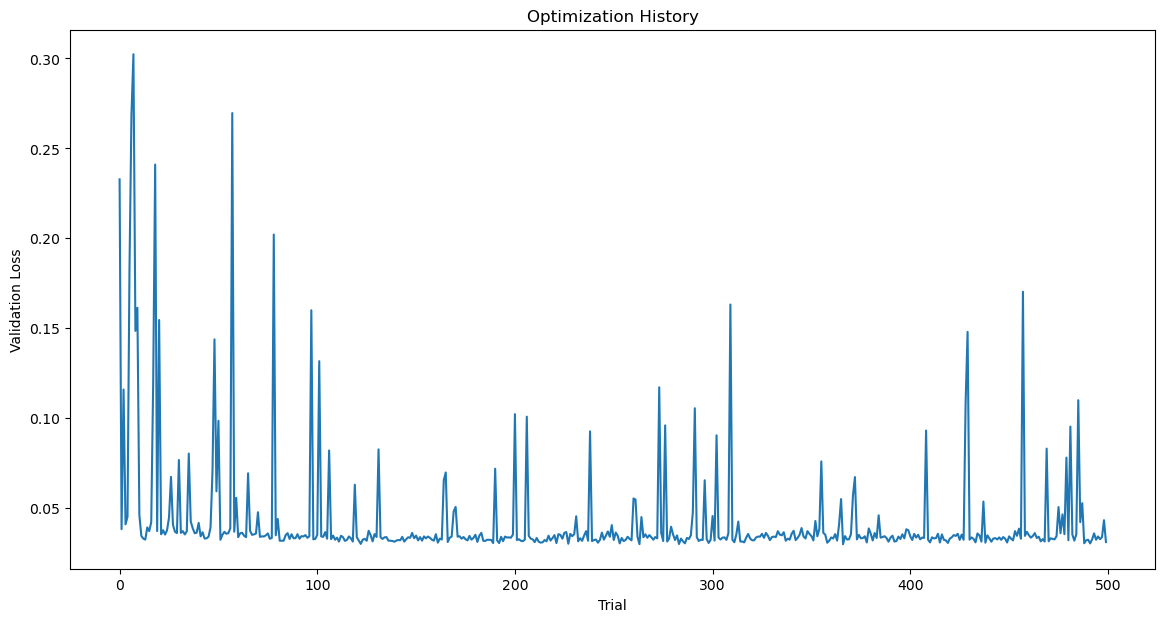

In [20]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(14, 7))
plt.plot(study.trials_dataframe().number, study.trials_dataframe().value)
plt.xlabel('Trial')
plt.ylabel('Validation Loss')
plt.title('Optimization History')
plt.show()

In [22]:
best_params =   study.best_params
hidden1_size =  best_params['hidden1_size']
hidden2_size =  best_params['hidden2_size']
hidden3_size =   best_params['hidden3_size']
hidden4_size =   best_params['hidden4_size']
num_epochs =    best_params['num_epochs']
learning_rate = best_params['learning_rate']

print(best_params)

{'hidden1_size': 76, 'hidden2_size': 128, 'hidden3_size': 93, 'hidden4_size': 47, 'num_epochs': 15, 'learning_rate': 1.1398647529848385e-05}


Epoch [1/15], Train Loss: 0.63983388, Val Loss: 0.62884898, ROC-AUC: 0.2421
Epoch [2/15], Train Loss: 0.61039473, Val Loss: 0.58831972, ROC-AUC: 0.3243
Epoch [3/15], Train Loss: 0.55063792, Val Loss: 0.50404205, ROC-AUC: 0.3578
Epoch [4/15], Train Loss: 0.42942585, Val Loss: 0.35244230, ROC-AUC: 0.3369
Epoch [5/15], Train Loss: 0.26971940, Val Loss: 0.20414021, ROC-AUC: 0.3349
Epoch [6/15], Train Loss: 0.14506396, Val Loss: 0.11312243, ROC-AUC: 0.3366
Epoch [7/15], Train Loss: 0.07728585, Val Loss: 0.06990699, ROC-AUC: 0.3372
Epoch [8/15], Train Loss: 0.04509873, Val Loss: 0.05021146, ROC-AUC: 0.3429
Epoch [9/15], Train Loss: 0.02879114, Val Loss: 0.04043846, ROC-AUC: 0.3489
Epoch [10/15], Train Loss: 0.02053644, Val Loss: 0.03625274, ROC-AUC: 0.3536
Epoch [11/15], Train Loss: 0.01621927, Val Loss: 0.03434664, ROC-AUC: 0.3594
Epoch [12/15], Train Loss: 0.01371408, Val Loss: 0.03353718, ROC-AUC: 0.3644
Epoch [13/15], Train Loss: 0.01216689, Val Loss: 0.03327311, ROC-AUC: 0.3692
Epoch [1

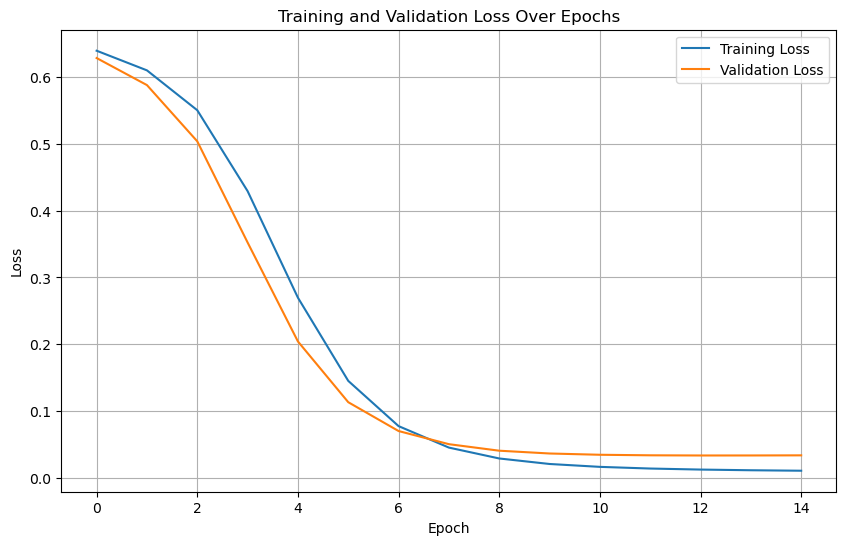

Test ROC-AUC: 0.6839
Number of incorrect predictions: 8
Sample 1: True Label = 1.0, Predicted = 0.0, Input Data = [[-1.69466996e+00 -1.01708555e+00 -4.06440705e-01 -3.17016616e-02
   4.34458852e-01  1.20239116e-01]
 [-1.27097034e+00  2.56051034e-01  5.67356706e-01 -1.25997353e+00
   6.51209176e-01  2.48569727e+00]
 [ 6.35678172e-01 -8.89771938e-01 -9.94823277e-01  2.14760256e+00
  -1.08410275e+00  1.53212833e+00]
 [ 2.11978540e-01  7.65305698e-01  1.92516565e+00 -1.30774093e+00
  -6.50601923e-01  1.36073303e+00]
 [-8.47270668e-01 -8.89771938e-01 -1.79285169e+00  1.39528537e+00
   4.34633255e-01  5.27880669e-01]
 [ 4.23828363e-01  1.01993299e+00 -5.34692466e-01 -3.49193722e-01
   8.68395925e-01  9.59453106e-01]
 [-6.35420859e-01  4.47021514e-01  1.41795444e+00  5.84639132e-01
  -1.97456634e+00  4.31282949e+00]
 [ 2.11978540e-01 -1.24625015e+00 -9.69364703e-01 -2.20248237e-01
   1.17718279e+00  1.56319335e-01]
 [ 4.23712540e+00  2.56051034e-01  1.22957826e+00 -1.40004992e+00
   1.3072694

In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EarthquakeClassifier(29 * 6, hidden1_size, hidden2_size, hidden3_size, hidden4_size, output_size=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader, val_loader, test_loader = create_dataloaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size=64)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Training loop
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)    
        
        # Forward pass
        outputs = model(inputs).squeeze(-1)  # No sigmoid since using BCEWithLogitsLoss
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Average train loss for the epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Save true labels and predictions for ROC-AUC calculation
            y_true.append(targets.cpu().numpy())
            y_pred.append(torch.sigmoid(outputs).cpu().numpy())  # Apply sigmoid to convert logits to probabilities
    
    # Concatenate results to flatten them
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Val Loss: {val_loss / len(val_loader):.8f}, ROC-AUC: {roc_auc:.4f}')
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Final Test Evaluation
model.eval()
y_true_test = []
y_pred_test = []
incorrect_samples = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze(-1)
        preds = torch.sigmoid(outputs)  # Convert logits to probabilities
        
        # Store true labels and predictions for final evaluation
        y_true_test.append(targets.cpu().numpy())
        y_pred_test.append(preds.cpu().numpy())
        
        # Collect incorrect predictions
        pred_labels = (preds > 0.5).float()  # Threshold the probabilities at 0.5
        incorrect_mask = (pred_labels != targets).cpu().numpy()  # Check where predictions are incorrect
        incorrect_samples.extend(list(zip(inputs.cpu().numpy()[incorrect_mask], targets.cpu().numpy()[incorrect_mask], pred_labels.cpu().numpy()[incorrect_mask])))

# Flatten y_true_test and y_pred_test
y_true_test = np.concatenate(y_true_test)
y_pred_test = np.concatenate(y_pred_test)

# Calculate ROC-AUC for the test set
roc_auc_test = roc_auc_score(y_true_test, y_pred_test)
print(f'Test ROC-AUC: {roc_auc_test:.4f}')

# Show incorrect predictions
print(f"Number of incorrect predictions: {len(incorrect_samples)}")
for i, (input_data, true_label, pred_label) in enumerate(incorrect_samples[:10], 1):  # Show first 10 incorrect predictions
    print(f"Sample {i}: True Label = {true_label}, Predicted = {pred_label}, Input Data = {input_data}")
